# Query Performance Comparison Across Datasets

This notebook compares query performance between different methods across all available datasets. It focuses on:
- Comparing query execution times between standard and cached queries
- Analyzing performance by dataset and operation type
- Visualizing performance differences with clear and concise plots
- Aggregating results across multiple runs for more robust comparisons

In [337]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re  # Add this import for regular expressions
from pathlib import Path
import scipy.stats as stats
import warnings
import matplotlib.ticker as ticker
import colorsys
import matplotlib.gridspec as gridspec

warnings.filterwarnings('ignore')

DATASET_MAP = {
    "intel_lab_exp": "INTL",
    "soccer_exp": "SOCC",
    "manufacturing_exp": "MNF",
}
FONT_SIZE = {
    'title': 22,
    'xlabel': 18,
    'ylabel': 18,
    'xtick': 16,
    'ytick': 16,
    'legend': 16,
    'figure': 12,
    'figsize': [16, 6]
}

# Set publication-ready plotting style
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Times New Roman', 'Palatino', 'DejaVu Serif'],
    'font.size': FONT_SIZE['figure'],
    'axes.titlesize': FONT_SIZE['title'],
    'axes.labelsize': FONT_SIZE['xlabel'],
    'xtick.labelsize': FONT_SIZE['xtick'],
    'ytick.labelsize': FONT_SIZE['ytick'],
    'legend.fontsize': FONT_SIZE['legend'],
    'figure.figsize': FONT_SIZE['figsize'],
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.axisbelow': True,
    'axes.labelpad': 10
})

# Generate a publication-ready color palette
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4))

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % tuple(int(255*x) for x in rgb)

def generate_palette(base_color, n=6, mode='tints_shades'):
    rgb = hex_to_rgb(base_color)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    palette = []
    if mode == 'tints_shades':
        levels = np.linspace(0.2, 0.8, n)
        for i, lv in enumerate(levels):
            new_rgb = colorsys.hls_to_rgb(h, lv, s)
            palette.append(rgb_to_hex(new_rgb))
    elif mode == 'analogous':
        for i in range(n):
            nh = (h + (i - n//2)*0.08) % 1.0
            new_rgb = colorsys.hls_to_rgb(nh, l, s)
            palette.append(rgb_to_hex(new_rgb))
    else:
        raise ValueError('Unknown mode')
    return palette


# GLOBAL METHOD COLORS DICTIONARY - Maps method names to colors
GLOBAL_METHOD_COLORS = {
    "M4-NoC": "#1f77b4",  # Blue
    "M4$^\\infty$-C": "#2ca02c",  # Orange
    "MinMaxCache": "#d62728",  # Green
    "M4-C": "#ff7f0e",  # rdd
    "M2$^\\infty$-C": "#9467bd",  # Orange
    "M2$^\\infty$-VIS": "#8c564b",  # Purple

}

mode = 1
SHOW_TITLES = 0

if(mode == 0):
    # Define output folders for first-last mode
    outFolder = "output_no_allocation"
    groundTruthFolder = "output_no_allocation"

    # Define the methods to compare
    METHODS = [
        {
            "name": "M4-NoC",
            "path": f"../{groundTruthFolder}/timeM4Queries/",
            "method": "m4",
            "database": "influx"
        },
        {
            "name": "M4$^\\infty$-C",
            "path": f"../{outFolder}/timeCacheQueries/",
            "method": "m4Inf",
            "database": "influx"
        },
        {
            "name": "M2$^\\infty$-C",
            "path": f"../{outFolder}/timeCacheQueries/",
            "method": "minmax",
            "database": "influx"
        },
        {
            "name": "MinMaxCache",
            "path": f"../{outFolder}/timeMinMaxCacheQueries/",
            "method": "minmaxcache",
            "database": "influx"
        },
        {
            "name": "M4-C",
            "path": f"../{outFolder}/timeCacheQueries/",
            "method": "m4",
            "database": "influx"
        },
    ]
elif(mode == 1):
    # Define output folders for slope mode
    outFolder = "output_slope"
    groundTruthFolder = "output_slope"
    # Define the methods to compare
    METHODS = [
        {
            "name": "M4-NoC",
            "path": f"../{outFolder}/timeOlsQueries/",
            "method": "ols",
            "database": "influx"
        },
        {
            "name": "M2$^\\infty$-C",
            "path": f"../{outFolder}/timeCacheQueries/",
            "method": "approxOls",
            "database": "influx"
        },
        # {
        #     "name": "M2$^\\infty$-VIS",
        #     "path": f"../{outFolder}/timeCacheQueries/",
        #     "method": "visual",
        #     "database": "influx"
        # },
    ]
elif(mode == 2):
    noAllocFolder = "output_no_allocation"
    outFolder = "output_with_allocation_"
    groundTruthFolder = "output_no_allocation"
    percs = ["1p", "10p"]
    
    METHODS = [
        # {
        #     "name": f"M4$^\\infty$-C",
        #     "path": f"../{noAllocFolder}/timeCacheQueries/",
        #     "method": "m4Inf",
        #     "database": "influx"
        # }, 
        ]
    for perc in percs:
        METHODS.append({
            "name": f"M4$^\\infty$-C ({perc.replace('p', '%')})",
            "path": f"../{outFolder}{perc}/timeCacheQueries/",
            "method": "m4Inf",
            "database": "influx"
        })
    palette = generate_palette(GLOBAL_METHOD_COLORS["M4$^\\infty$-C"], n=len(percs), mode='tints_shades')
    for i, color in enumerate(palette):
        GLOBAL_METHOD_COLORS[f"M4$^\\infty$-C ({percs[i].replace('p', '%')})"] = color
else:
    raise ValueError("Invalid mode selected. Use 0 for first-last or 1 for slope.")

# outFolder = "output_slope"
# groundTruthFolder = "output_slope"

plt.rcParams['text.usetex'] = False  # Set to True only if you have LaTeX installed
plt.rcParams['mathtext.default'] = 'regular'

# Create a folder for saving publication-ready figures
FIGURES_DIR = "../figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

# Define a consistent style function for publication-ready plots
def set_publication_style(ax, title=None, xlabel=None, ylabel=None, legend_title=None):
    """Apply consistent publication-ready styling to matplotlib axis"""
    if title:
        ax.set_title(title, fontweight='bold', pad=15, fontsize=FONT_SIZE['title'])
    if xlabel:
        ax.set_xlabel(xlabel, fontweight='bold', fontsize=FONT_SIZE['xlabel'])
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='bold', fontsize=FONT_SIZE['ylabel'])
    
    # Apply grid style
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    
    # Style spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    # # Format legend if it exists
    if ax.get_legend():
        if legend_title:
            ax.legend(title=legend_title, frameon=True, facecolor='white', 
                     framealpha=0.9, edgecolor='black',title_fontsize=FONT_SIZE["legend"], fontsize = FONT_SIZE['legend'])
        else:
            ax.legend(frameon=True, facecolor='white', 
                     framealpha=0.9, edgecolor='black', fontsize = FONT_SIZE['legend'])
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

In [338]:
GLOBAL_METHOD_COLORS

{'M4-NoC': '#1f77b4',
 'M4$^\\infty$-C': '#2ca02c',
 'MinMaxCache': '#d62728',
 'M4-C': '#ff7f0e',
 'M2$^\\infty$-C': '#9467bd',
 'M2$^\\infty$-VIS': '#8c564b'}

## Load Query Results Data

Load experiment results from all available datasets, aggregating across runs.

In [339]:
def load_results(base_path, method, database_type, table_name):
    """
    Load results from multiple experiment runs into a single dataframe
    
    Parameters:
    -----------
    base_path : str
        Base path to the queries directory
    method : str    
        Name of the method used (e.g., m4Inf, m4)
    database_type : str
        Type of database (influx, postgres, etc.)
    table_name : str
        Name of the database table
        
    Returns:
    --------
    pd.DataFrame or None: Combined results from all runs
    """
    path_pattern = os.path.join(base_path, method, database_type, table_name, "run_*", "results.csv")
    csv_files = glob.glob(path_pattern)
    
    if not csv_files:
        return None
    
    dfs = []
    for csv_file in csv_files:
        run_name = os.path.basename(os.path.dirname(csv_file))
        df = pd.read_csv(csv_file)
        df['run'] = run_name
        df['dataset'] = DATASET_MAP[table_name]
        df['query_type'].fillna('Initial Query', inplace=True)  # Fill NaN values in query_type
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Debug: Check if query 0 exists in raw data
    if 0 in combined_df['query #'].values:
        print(f"    Query 0 found in raw data for {method}/{table_name}")
    else:
        print(f"    Query 0 NOT found in raw data for {method}/{table_name}")
    
    # Convert date columns to datetime if they exist
    date_columns = ['from', 'to']
    for col in date_columns:
        if col in combined_df.columns:
            combined_df[col] = pd.to_datetime(combined_df[col])
            
    # Add duration column
    if 'from' in combined_df.columns and 'to' in combined_df.columns:
        combined_df['duration_sec'] = (combined_df['to'] - combined_df['from']).dt.total_seconds()
    
    return combined_df

# Function to detect and filter out outlier runs
def filter_outlier_runs(df, outlier_threshold=2.0):
    """
    Filter out runs that have significantly different execution times compared to other runs
    for the same query using the Interquartile Range (IQR) method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing results from multiple runs
    outlier_threshold : float
        IQR multiplier for outlier detection (default: 2.0 for more conservative filtering)
        
    Returns:
    --------
    pd.DataFrame: DataFrame with outlier runs removed
    """
    if df is None or len(df) == 0:
        return df
    
    # Debug: Check if query 0 exists before filtering
    if 0 in df['query #'].values:
        print(f"    Query 0 found before outlier filtering")
    
    # Group by query characteristics to identify the same query across runs
    groupby_cols = ['dataset', 'query #', 'query_type']
    group_cols = [col for col in groupby_cols if col in df.columns]
    filtered_dfs = []
    outliers_removed = 0
    
    for group_key, group_df in df.groupby(group_cols):
        # Always preserve query 0 without filtering
        if group_key[1] == 0:  # query # is the second element in the group key
            filtered_dfs.append(group_df)
            continue
        if len(group_df) <= 2:  # Don't filter if we have 2 or fewer runs
            filtered_dfs.append(group_df)
            continue
        
        # Calculate IQR for execution times
        times = group_df['Time (sec)']
        Q1 = times.quantile(0.25)
        Q3 = times.quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - outlier_threshold * IQR
        upper_bound = Q3 + outlier_threshold * IQR
        
        # Filter out outliers
        mask = (times >= lower_bound) & (times <= upper_bound)
        filtered_group = group_df[mask]
        
        # Only apply filtering if we still have at least 2 runs after filtering
        if len(filtered_group) >= 2:
            outliers_removed += len(group_df) - len(filtered_group)
            filtered_dfs.append(filtered_group)
        else:
            # Keep original data if filtering would leave us with too few runs
            filtered_dfs.append(group_df)
    
    if filtered_dfs:
        result_df = pd.concat(filtered_dfs, ignore_index=True)
        if outliers_removed > 0:
            print(f"    Filtered out {outliers_removed} outlier runs")        
        return result_df
    else:
        return df

# Function to aggregate results from multiple runs
def aggregate_runs(df):
    """
    Aggregate results from multiple runs by grouping by query characteristics
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing results from multiple runs
        
    Returns:
    --------
    pd.DataFrame: Aggregated results with statistics across runs
    """
    if df is None or len(df) == 0:
        return None

    # First, filter out outlier runs
    df_filtered = filter_outlier_runs(df)
    
    # Group by query characteristics (not by run)
    groupby_cols = ['dataset', 'query #', 'query_type']
    group_cols = [col for col in groupby_cols if col in df_filtered.columns]
    
    # Aggregate the Time (sec) column across runs
    agg_df = df_filtered.groupby(group_cols).agg({
        'Init Time (sec)': ['mean'],  # Initial query time
        'Time (sec)': ['mean', 'median', 'std', 'min', 'max', 'count'],
        'IO Count': 'mean',  # Average IO Count
        'Cache Hits (%)': 'mean',  # Average Cache Hits Percentage
        'Cache Size (bytes)': 'mean',  # Average Cache Size in bytes
        'run': 'nunique'  # Count number of runs
    }).reset_index()
    
    # Flatten the multi-level column names
    agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in agg_df.columns]
    
    # Rename some columns for clarity
    agg_df = agg_df.rename(columns={
        'Time (sec)_mean': 'Time (sec)', 
        'Time (sec)_count': 'query_count',
        'run_nunique': 'run_count'
    })

    print(f"    Query numbers in final data: {sorted(agg_df['query #'].unique())}")
    
    return agg_df

# Operation type mapping for better readability
def get_operation_type_mapping():
    return {
        'P': 'Pan',
        'ZI': 'Zoom In',
        'ZO': 'Zoom Out',
        'R': 'Resize',
        'MC': 'Measure Change',
        'PD': 'Pattern Detection',
        'NaN': 'Initial Query'
    }

## Find All Available Datasets and Load Data

In [340]:
# Query Data Loading and Aggregation - CALCULATION CELL
# This cell loads raw query data, performs aggregation, and caches the results

def find_datasets(method_info):
    """Find all available datasets by looking at directories"""
    base_path = method_info["path"]
    method = method_info["method"]
    database = method_info["database"]
    
    # Find all dataset directories
    dataset_pattern = os.path.join(base_path, method, database, "*")
    datasets = []
    
    for dataset_dir in glob.glob(dataset_pattern):
        if os.path.isdir(dataset_dir):
            dataset_name = os.path.basename(dataset_dir)
            datasets.append(dataset_name)
    
    return datasets


print("Computing query results from scratch...")

# Get unique datasets from all methods
all_datasets = set()
for method in METHODS:
    datasets = find_datasets(method)
    all_datasets.update(datasets)
all_datasets = sorted(list(all_datasets))
print(f"Found {len(all_datasets)} datasets: {all_datasets}")
# Load data for each method and dataset
raw_results_by_dataset = {}  # Store raw results
results_by_dataset = {}      # Store aggregated results
all_results = []             # Store all aggregated results
for dataset in all_datasets:
    print(f"\nLoading data for dataset: {dataset}")
    dataset_results = []
    dataset_raw_results = []
    
    for i, method in enumerate(METHODS):
        print(f"  Loading {method['name']}...")
        
        df = load_results(
            base_path=method['path'],
            method=method['method'],
            database_type=method['database'],
            table_name=dataset
        )
        
        if df is not None and not df.empty:
            # Add method name and color index
            df['method'] = method['name']
            df['method_idx'] = i
            
            # Add readable operation type
            op_type_map = get_operation_type_mapping()
            df['operation'] = df.apply(
                lambda row: 'Initial Query' if pd.isna(row['query_type']) else op_type_map.get(row['query_type'], row['query_type']), 
                axis=1
            )
            
            # Store raw results first
            dataset_raw_results.append(df)
            
            # Aggregate results across runs
            agg_df = aggregate_runs(df)
            
            if agg_df is not None:
                # Add method name and operation type to aggregated data
                agg_df['method'] = method['name']
                agg_df['method_idx'] = i
                agg_df['operation'] = agg_df.apply(
                    lambda row: 'Initial Query' if pd.isna(row['query_type']) else op_type_map.get(row['query_type'], row['query_type']), 
                    axis=1
                )
                
                dataset_results.append(agg_df)
                all_results.append(agg_df)
                print(f"    Loaded {len(df)} queries from {agg_df['run_count'].iloc[0]} runs, aggregated to {len(agg_df)} unique queries")
            else:
                print(f"    Error aggregating results")
        else:
            print(f"    No data found")
    
    if dataset_raw_results:
        raw_results_by_dataset[DATASET_MAP[dataset]] = pd.concat(dataset_raw_results, ignore_index=True)
    
    if dataset_results:
        results_by_dataset[DATASET_MAP[dataset]] = pd.concat(dataset_results, ignore_index=True)
# Combine all results into a single dataframe for overall analysis
if all_results:
    all_combined = pd.concat(all_results, ignore_index=True)
    print(f"\nLoaded a total of {len(all_combined)} aggregated queries across {len(all_datasets)} datasets")
    
    # Print run count information
    for dataset in results_by_dataset:
        for method in METHODS:
            method_name = method['name']
            method_data = results_by_dataset[dataset][results_by_dataset[dataset]['method'] == method_name]
            if not method_data.empty:
                run_count = method_data['run_count'].iloc[0]
                print(f"Dataset: {dataset}, Method: {method_name}, Runs: {run_count}")
else:
    all_combined = None
    print("\nNo data was loaded.")

all_datasets_mapped = [DATASET_MAP[dataset] for dataset in all_datasets]

Computing query results from scratch...
Found 3 datasets: ['intel_lab_exp', 'manufacturing_exp', 'soccer_exp']

Loading data for dataset: intel_lab_exp
  Loading M4-NoC...
    Query 0 found in raw data for ols/intel_lab_exp
    Query 0 found before outlier filtering
    Query numbers in final data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(

In [341]:
all_combined

,dataset,query #,query_type,Init Time (sec)_mean,Time (sec),Time (sec)_median,Time (sec)_std,Time (sec)_min,Time (sec)_max,query_count,IO Count_mean,Cache Hits (%)_mean,Cache Size (bytes)_mean,run_count,method,method_idx,operation
0,INTL,0,Initial Query,-1.0,0.863168,0.863168,NaN,0.863168,0.863168,1,NaN,NaN,NaN,1,M4-NoC,0,Initial Query
1,INTL,1,ZI,-1.0,0.550456,0.550456,NaN,0.550456,0.550456,1,NaN,NaN,NaN,1,M4-NoC,0,Zoom In
2,INTL,2,P,-1.0,0.610573,0.610573,NaN,0.610573,0.610573,1,NaN,NaN,NaN,1,M4-NoC,0,Pan
3,INTL,3,PD,-1.0,25.411459,25.411459,NaN,25.411459,25.411459,1,NaN,NaN,NaN,1,M4-NoC,0,Pattern Detection
4,INTL,4,ZI,-1.0,0.687716,0.687716,NaN,0.687716,0.687716,1,NaN,NaN,NaN,1,M4-NoC,0,Zoom In
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,SOCC,46,ZO,0.0,0.028073,0.028073,NaN,0.028073,0.028073,1,0.0,100.0,1846904.0,1,M2$^\infty$-C,1,Zoom Out
302,SOCC,47,ZO,0.0,0.042079,0.042079,NaN,0.042079,0.042079,1,0.0,100.0,1846904.0,1,M2$^\infty$-C,1,Zoom Out
303,SOCC,48,P,0.0,0.041393,0.041393,NaN,0.041393,0.041393,1,0.0,100.0,1846904.0,1,M2$^\infty$-C,1,Pan
304,SOCC,49,P,0.0,0.062338,0.062338,NaN,0.062338,0.062338,1,0.0,100.0,1846904.0,1,M2$^\infty$-C,1,Pan


## Performance Comparison by Operation Type

Let's break down the performance by operation type for each dataset using the aggregated results.

In [342]:
COMBINED = True

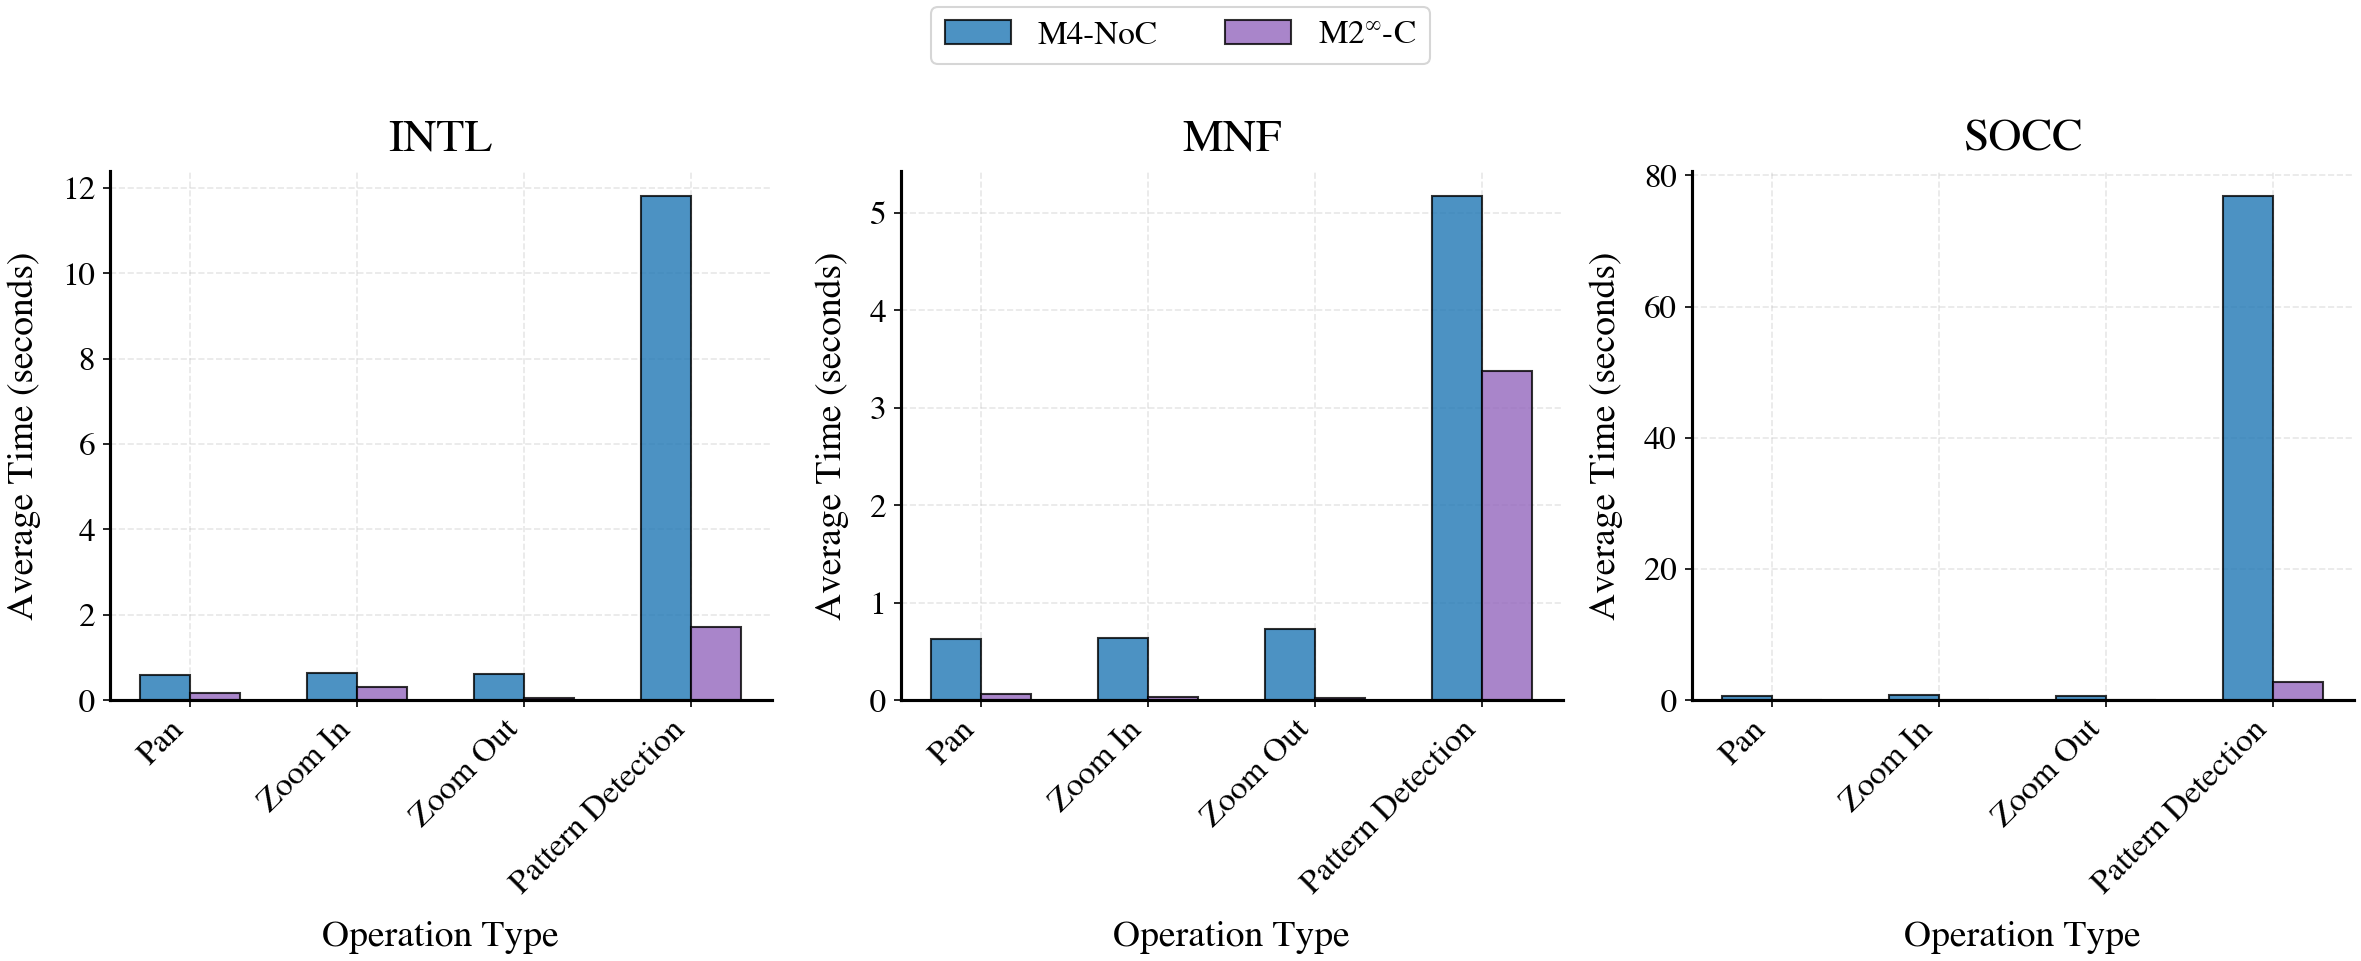

In [343]:
# Performance Comparison by Operation Type - COMBINED PLOTTING CELL
# This cell creates a single figure with subplots for all datasets

if 'all_combined' in globals() and all_combined is not None and 'results_by_dataset' in globals():
    # Get unique operations across all datasets
    all_ops = sorted(all_combined['operation'].unique())
    if COMBINED:
        # Create combined figure with subplots for all datasets
        n_datasets = len(all_datasets_mapped)
        cols = min(3, n_datasets)  # Max 3 columns
        rows = (n_datasets + cols - 1) // cols  # Calculate rows needed
        
        fig, axes = plt.subplots(rows, cols, figsize=(FONT_SIZE["figsize"][0], FONT_SIZE["figsize"][1]*rows))
        if n_datasets == 1:
            axes = [axes]
        elif rows == 1:
            axes = [axes] if cols == 1 else axes
        else:
            axes = axes.flatten()
        
        # Hide extra subplots if any
        for i in range(n_datasets, len(axes)):
            axes[i].set_visible(False)
        
        for i, dataset in enumerate(all_datasets_mapped):
            ax = axes[i]
            
            if dataset in results_by_dataset:
                dataset_df = results_by_dataset[dataset]
                method_names = dataset_df['method'].unique()
                run_count = dataset_df['run_count'].iloc[0]
                
                # Group data by operation type and method
                op_perf = dataset_df.groupby(['operation', 'method'])['Time (sec)'].mean().reset_index()
                op_perf = op_perf.dropna(subset=['operation'])
                
                # Get operations for this dataset and sort them
                operations = op_perf['operation'].unique()
                # Remove 'Initial Query' for operation plots
                operations = [op for op in operations if op != 'Initial Query']
                op_order = ['Initial Query', 'Pan', 'Zoom In', 'Zoom Out', 'Resize', 'Measure Change', 'Pattern Detection']
                operations = sorted(operations, key=lambda x: op_order.index(x) if x in op_order else 999)
                
                # Set bar properties
                bar_width = 0.6 / len(method_names)
                opacity = 0.8
                bar_positions = np.arange(len(operations))
                
                method_handles = []
                
                for j, method in enumerate(method_names):
                    method_data = op_perf[op_perf['method'] == method]
                    method_by_op = {row['operation']: row['Time (sec)'] for _, row in method_data.iterrows()}
                    values = [method_by_op.get(op, 0) for op in operations]
                    
                    offset = (j - len(method_names)/2 + 0.5) * bar_width
                    bars = ax.bar(
                        bar_positions + offset, 
                        values, 
                        bar_width,
                        color=GLOBAL_METHOD_COLORS[method], 
                        label=method,
                        edgecolor='black',
                        linewidth=1,
                        alpha=opacity
                    )
                    method_handles.append(bars)
                                
                
                # Set labels and formatting
                ax.set_xticks(bar_positions)
                ax.set_xticklabels(operations, rotation=45, ha='right')
                ax.set_title(f'{dataset}', fontweight='bold', pad=10)
                ax.set_xlabel('Operation Type')
                ax.set_ylabel('Average Time (seconds)')
                
                # Collect legend handles from the first dataset only
                if i == 0:
                    legend_handles = method_handles
                
                # Apply styling
                set_publication_style(ax)
            else:
                ax.text(0.5, 0.5, f'No data\nfor {dataset}', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{dataset}', fontweight='bold', pad=10)
        
        # Add figure-wide legend at the top
        if 'legend_handles' in locals():
            fig.legend(handles=legend_handles,
                      loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(method_names),
                      frameon=True)
        
        # Set overall title
        if SHOW_TITLES:
            fig.suptitle('Query Performance by Operation Type - All Datasets', fontsize=FONT_SIZE['title'], y=0.92)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.87 if SHOW_TITLES else 0.90)
        
        # Save combined figure
        plt.savefig(os.path.join(FIGURES_DIR, "operations_combined.pdf"))
        plt.savefig(os.path.join(FIGURES_DIR, "operations_combined.png"))
        plt.show()
    else:
        # Create publication-ready figures for each dataset separately
        for i, dataset in enumerate(all_datasets):
            if dataset in results_by_dataset:
                dataset_df = results_by_dataset[dataset]
                method_names = dataset_df['method'].unique()
                run_count = dataset_df['run_count'].iloc[0]
                
                # Group data by operation type and method
                op_perf = dataset_df.groupby(['operation', 'method'])['Time (sec)'].mean().reset_index()
                
                # Remove rows with NaN operations to avoid plotting issues
                op_perf = op_perf.dropna(subset=['operation'])
                
                # Get operations for this dataset and sort them in a meaningful order
                operations = op_perf['operation'].unique()
                op_order = ['Initial Query', 'Pan', 'Zoom In', 'Zoom Out', 'Resize', 'Measure Change', 'Pattern Detection']
                operations = sorted(operations, key=lambda x: op_order.index(x) if x in op_order else 999)
                
                # Create the figure
                fig, ax = plt.subplots(figsize=(FONT_SIZE["figsize"][0], FONT_SIZE["figsize"][1]))
                
                # Set bar properties
                bar_width = 0.6 / len(method_names)
                opacity = 0.8
                bar_positions = np.arange(len(operations))
                
                method_handles = []  # Store handles for legend
                
                for j, method in enumerate(method_names):
                    method_data = op_perf[op_perf['method'] == method]
                    # Create a lookup dict by operation
                    method_by_op = {row['operation']: row['Time (sec)'] for _, row in method_data.iterrows()}
                    
                    # Extract values in the correct order
                    values = [method_by_op.get(op, 0) for op in operations]
                    
                    # Plot bars with consistent colors
                    offset = (j - len(method_names)/2 + 0.5) * bar_width
                    bars = ax.bar(
                        bar_positions + offset, 
                        values, 
                        bar_width,
                        color=GLOBAL_METHOD_COLORS[method], 
                        label=method,
                        edgecolor='black',
                        linewidth=1,
                        alpha=opacity
                    )
                    
                    # Add value labels on top of bars
                    for k, bar in enumerate(bars):
                        height = bar.get_height()
                        if height > 0:  # Only add labels for non-zero values
                            ax.text(
                                bar.get_x() + bar.get_width()/2,
                                height + 0.05,
                                f'{height:.2f}',
                                ha='center', 
                                va='bottom',
                                rotation=0
                            )
                
                # Set the x-axis labels
                ax.set_xticks(bar_positions)
                ax.set_xticklabels(operations, rotation=45, ha='right')
                
                # Set labels and title
                title = f'Query Performance by Operation Type - {dataset}'
                subtitle = f'Average across {run_count} runs'
                if(SHOW_TITLES):
                    ax.set_title(f'{title}\n{subtitle}', pad=20)
                ax.set_xlabel('Operation Type')
                ax.set_ylabel('Average Time (seconds)')
                # Create legend with pattern detection highlight (only once)
                legend_handles = method_handles
                
                # Create legend with custom handles
                ax.legend(handles=legend_handles, loc='upper right')
                    
                # Apply publication styling (legend will be created automatically from labels)
                set_publication_style(ax)
                
                # Adjust layout
                plt.tight_layout()
                
                # Save figure
                filename_safe = dataset.replace('/', '_').replace(' ', '_')
                plt.savefig(os.path.join(FIGURES_DIR, f"operations_{filename_safe}.pdf"))
                plt.savefig(os.path.join(FIGURES_DIR, f"operations_{filename_safe}.png"))
                plt.show()
else:
    print("No data available for comparison.")

## Query Execution Time Evolution

Let's visualize how query times evolve across the sequence of operations, highlighting pattern detection queries.

In [344]:
COMBINED = False


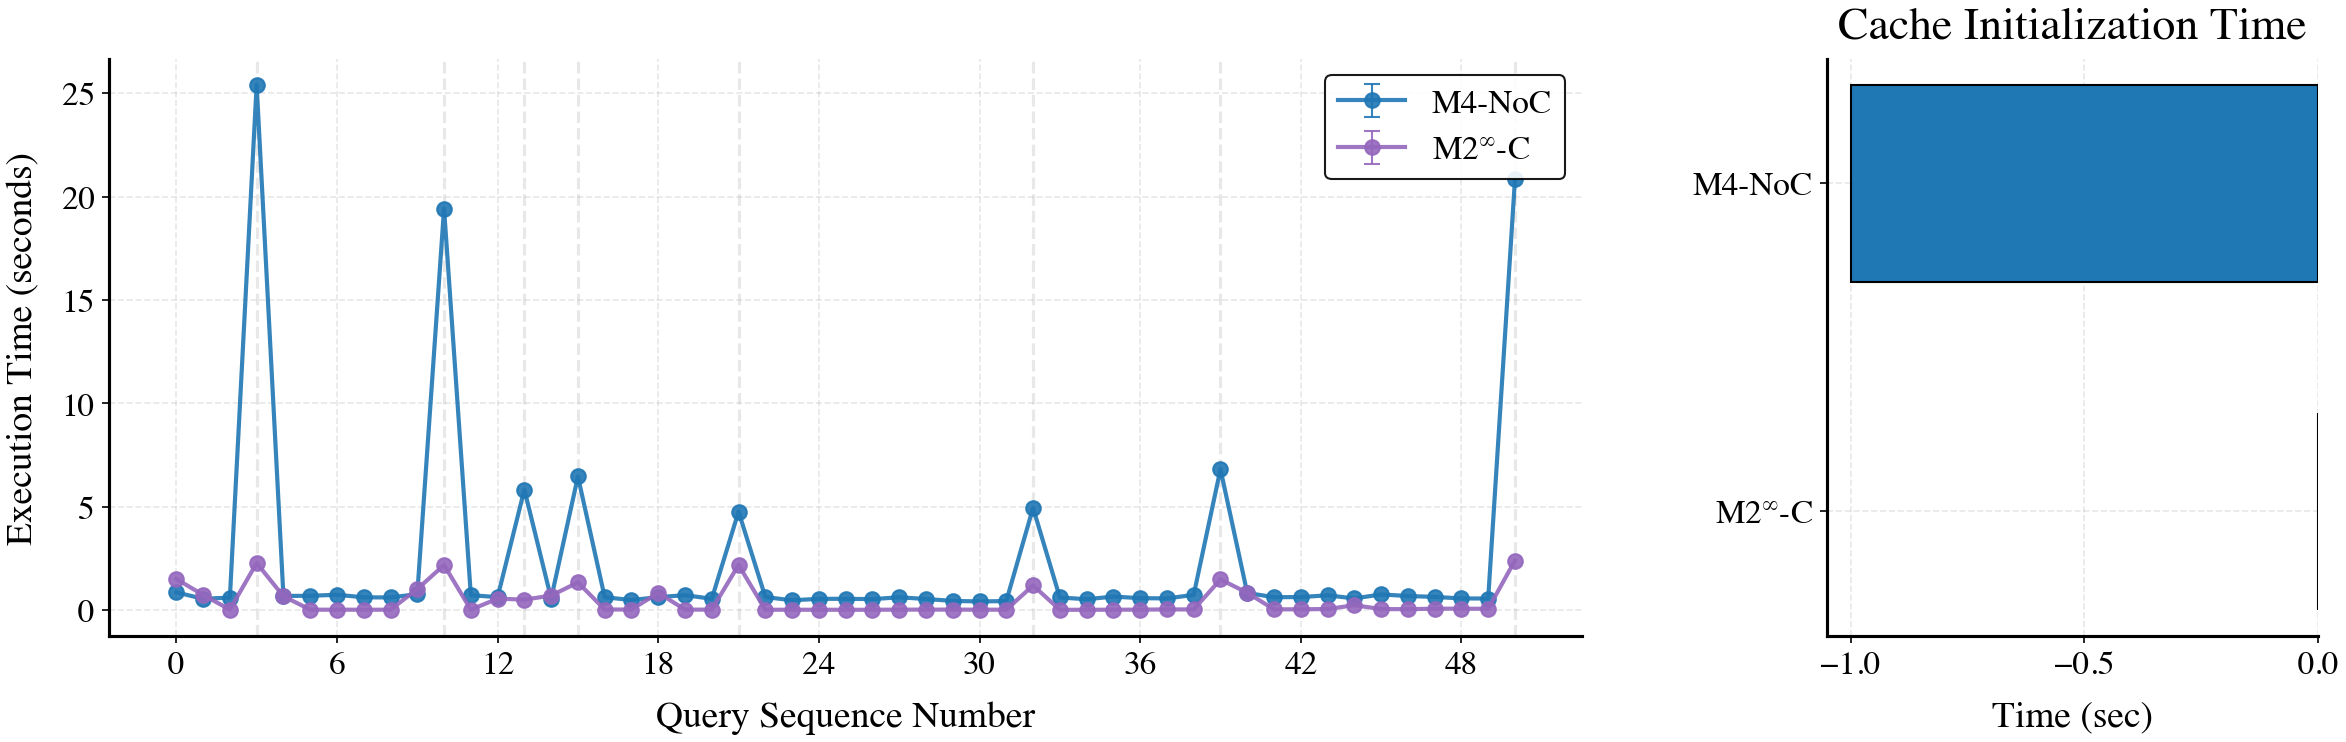

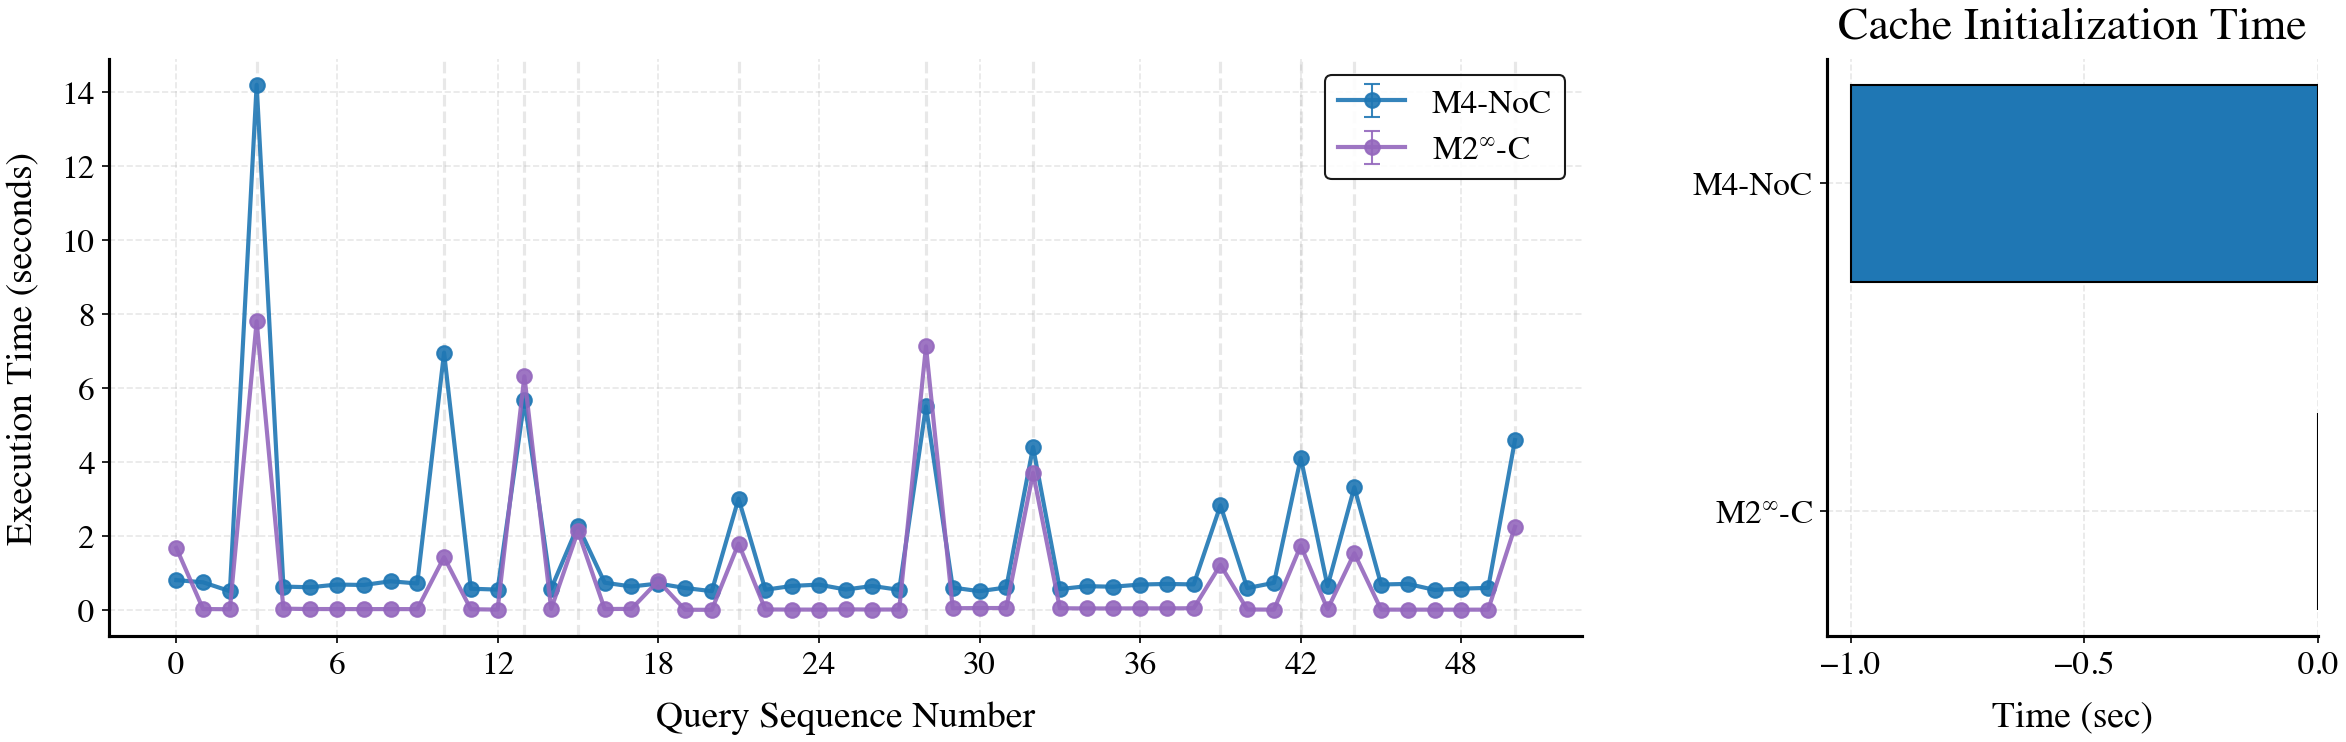

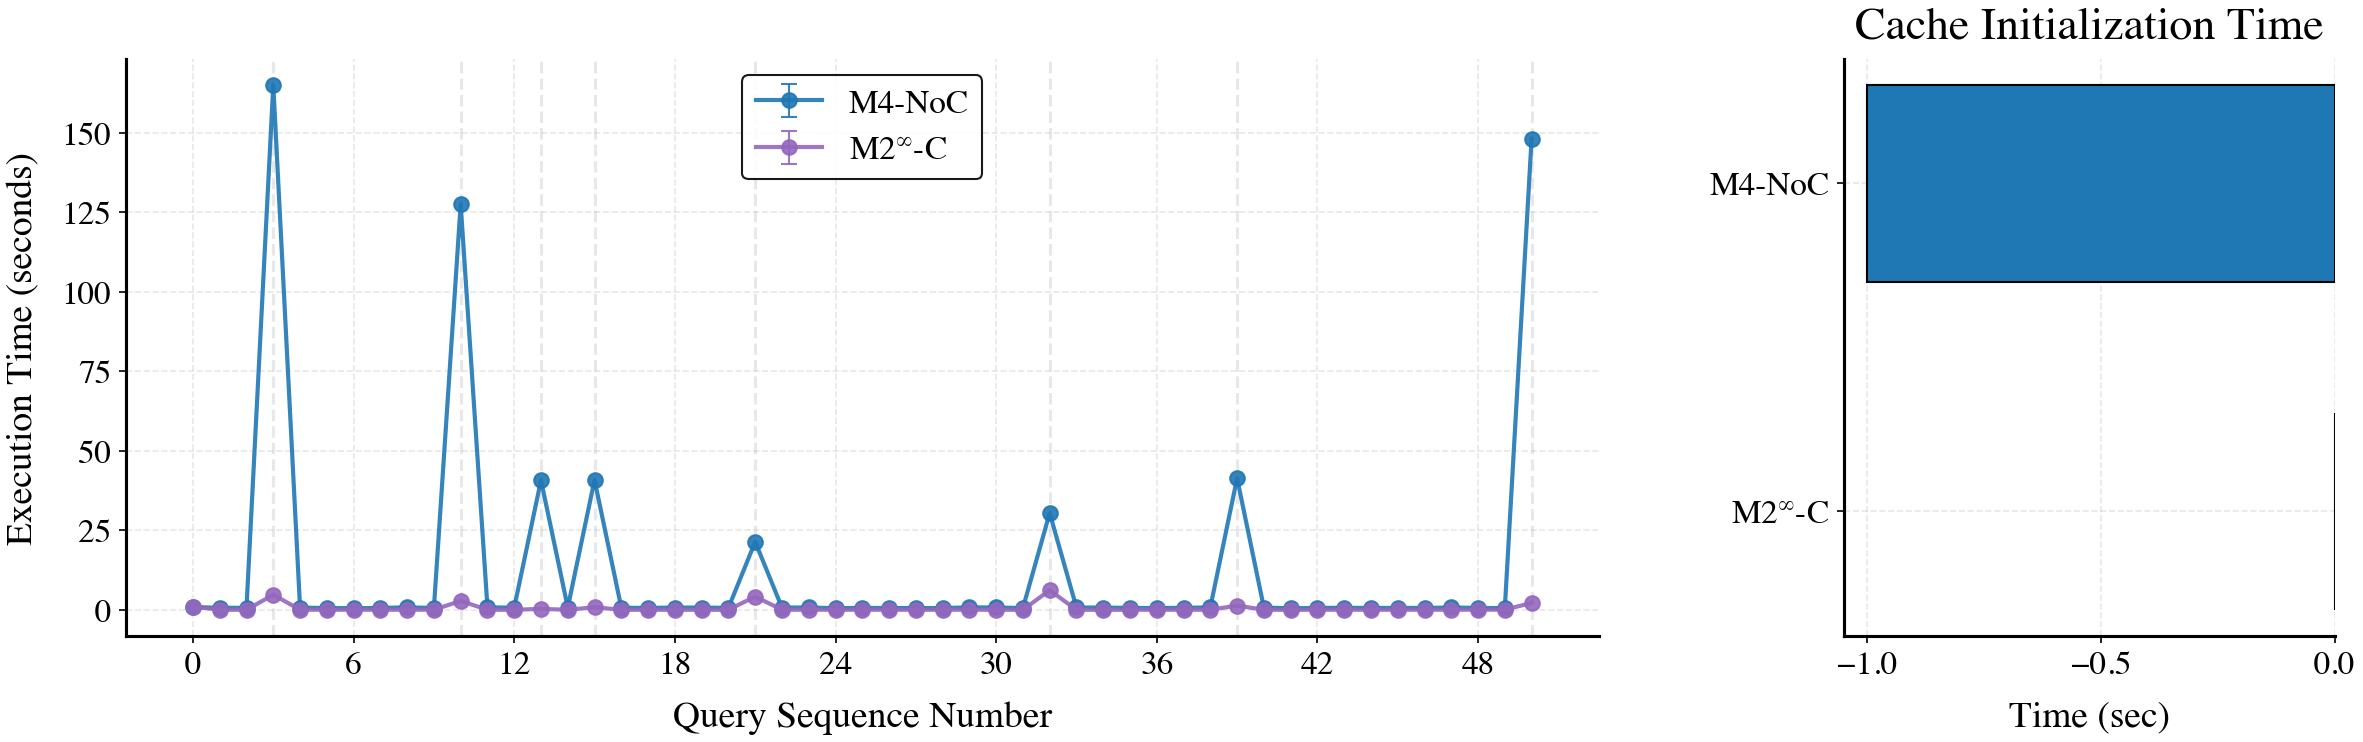

In [345]:
if all_combined is not None:
    if COMBINED:
        # Query Execution Time Evolution - COMBINED PLOTTING CELL
        # This cell creates a single figure with subplots for all datasets
            # Create combined figure with subplots for all datasets
        n_datasets = len(all_datasets_mapped)
        cols = min(3, n_datasets)
        rows = (n_datasets + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(FONT_SIZE["figsize"][0], FONT_SIZE["figsize"][1]*rows))
        if n_datasets == 1:
            axes = [axes]
        elif rows == 1:
            axes = [axes] if cols == 1 else axes
        else:
            axes = axes.flatten()
        
        # Hide extra subplots if any
        for i in range(n_datasets, len(axes)):
            axes[i].set_visible(False)
        
        for i, dataset in enumerate(all_datasets_mapped):
            ax = axes[i]
            
            if dataset in results_by_dataset:
                dataset_df = results_by_dataset[dataset]
                run_count = dataset_df['run_count'].iloc[0]
                methods = dataset_df['method'].unique()
                
                # Add highlighting for pattern detection queries
                pattern_queries = dataset_df[dataset_df['operation'] == 'Pattern Detection']['query #'].unique()
                for query_num in pattern_queries:
                    ax.axvline(x=query_num, color='lightgray', linestyle='--', alpha=0.5, zorder=0)

                # Define markers and plot each method
                markers = {'Pattern Detection': '*', 'Other': 'o'}
                method_handles = []
                
                for j, method in enumerate(methods):
                    method_data = dataset_df[dataset_df['method'] == method].sort_values('query #')
                    color = GLOBAL_METHOD_COLORS[method]
                    
                   
                    line = ax.errorbar(
                        method_data['query #'], 
                        method_data['Time (sec)'],
                        yerr=method_data['Time (sec)_std'],
                        label=method,
                        marker=markers['Other'], 
                        markersize=6, 
                        alpha=0.9,
                        color=color, 
                        linestyle='-', 
                        linewidth=2,
                        capsize=3,
                        capthick=1,
                        elinewidth=1
                    )
                    method_handles.append(line)
                
                # Set labels and formatting
                ax.set_title(f'{dataset}', fontweight='bold', pad=10)
                ax.set_xlabel('Query Sequence Number')
                ax.set_ylabel('Execution Time (seconds)')
                ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
                
                # Add legend only to the first subplot
                if i == 0:
                    ax.legend(handles=method_handles, loc='upper right')
                
                # Apply styling
                set_publication_style(ax)
            else:
                ax.text(0.5, 0.5, f'No data\nfor {dataset}', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{dataset}', fontweight='bold', pad=10)
        
        # Set overall title
        if SHOW_TITLES:
            fig.suptitle('Query Execution Time Evolution - All Datasets', fontsize=FONT_SIZE['title'], y=0.98)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.93 if SHOW_TITLES else 0.96)
        
        # Save combined figure
        plt.savefig(os.path.join(FIGURES_DIR, "time_evolution_combined.pdf"))
        plt.savefig(os.path.join(FIGURES_DIR, "time_evolution_combined.png"))
        plt.show()
    else:
        # Plot time series for each dataset
        for dataset in all_datasets_mapped:
            if dataset in results_by_dataset:
                dataset_df = results_by_dataset[dataset]
                run_count = dataset_df['run_count'].iloc[0]
                methods = dataset_df['method'].unique()
                markers = {'Pattern Detection': '*', 'Other': 'o'}
                
                # Set up the main plot and the bar plot on the side
                fig = plt.figure(figsize=(FONT_SIZE["figsize"][0]+3, (FONT_SIZE["figsize"][1] - 1)))
                gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.25)
                
                ax_main = plt.subplot(gs[0, 0])
                ax_bar = plt.subplot(gs[0, 1])
                
                # --- Main Time Evolution Plot ---
                pattern_queries = dataset_df[dataset_df['operation'] == 'Pattern Detection']['query #'].unique()
                for query_num in pattern_queries:
                    ax_main.axvline(x=query_num, color='lightgray', linestyle='--', alpha=0.5, zorder=0)
                
                method_handles = []
                for i, method in enumerate(methods):
                    method_data = dataset_df[dataset_df['method'] == method].sort_values('query #')
                    color = GLOBAL_METHOD_COLORS[method]
                    line = ax_main.errorbar(
                        method_data['query #'],
                        method_data['Time (sec)'],
                        yerr=method_data['Time (sec)_std'],
                        label=method,
                        marker=markers['Other'],
                        markersize=7,
                        alpha=0.9,
                        color=color,
                        linestyle='-',
                        linewidth=2,
                        capsize=4,
                        capthick=1,
                        elinewidth=1
                    )
                    method_handles.append(line)
                
                title = f'Query Execution Time Evolution - {dataset}'
                subtitle = f'Average of {run_count} runs with standard deviation'
                if SHOW_TITLES:
                    ax_main.set_title(f'{title}\n{subtitle}', pad=20)
                ax_main.set_xlabel('Query Sequence Number')
                ax_main.set_ylabel('Execution Time (seconds)')
                ax_main.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
                ax_main.legend(handles=method_handles, loc='upper right')
                set_publication_style(ax_main)
                
                # --- Side Bar Plot: Initial Query (query # == 0) ---
                initial_df = dataset_df[dataset_df['query #'] == 0]
                initial_times = [initial_df[initial_df['method'] == m]['Init Time (sec)_mean'].mean() for m in methods]
                bar_colors = [GLOBAL_METHOD_COLORS[m] for m in methods]
                ax_bar.barh(methods, initial_times, color=bar_colors, edgecolor='k', height=0.6)
                ax_bar.set_xlabel('Time (sec)')
                ax_bar.set_title('Cache Initialization Time', pad=10, fontsize=FONT_SIZE['title'])
                set_publication_style(ax_bar)
                ax_bar.invert_yaxis()  # methods from top to bottom
                
                # Remove y-labels from bar plot (to avoid duplication)
                ax_bar.set_ylabel('')
                
                plt.tight_layout()
                filename_safe = dataset.replace(' ', '_').lower()
                plt.savefig(os.path.join(FIGURES_DIR, f"time_evolution_{filename_safe}.pdf"))
                plt.savefig(os.path.join(FIGURES_DIR, f"time_evolution_{filename_safe}.png"))
                plt.show()
else:
    print("No data available for plotting time evolution.")

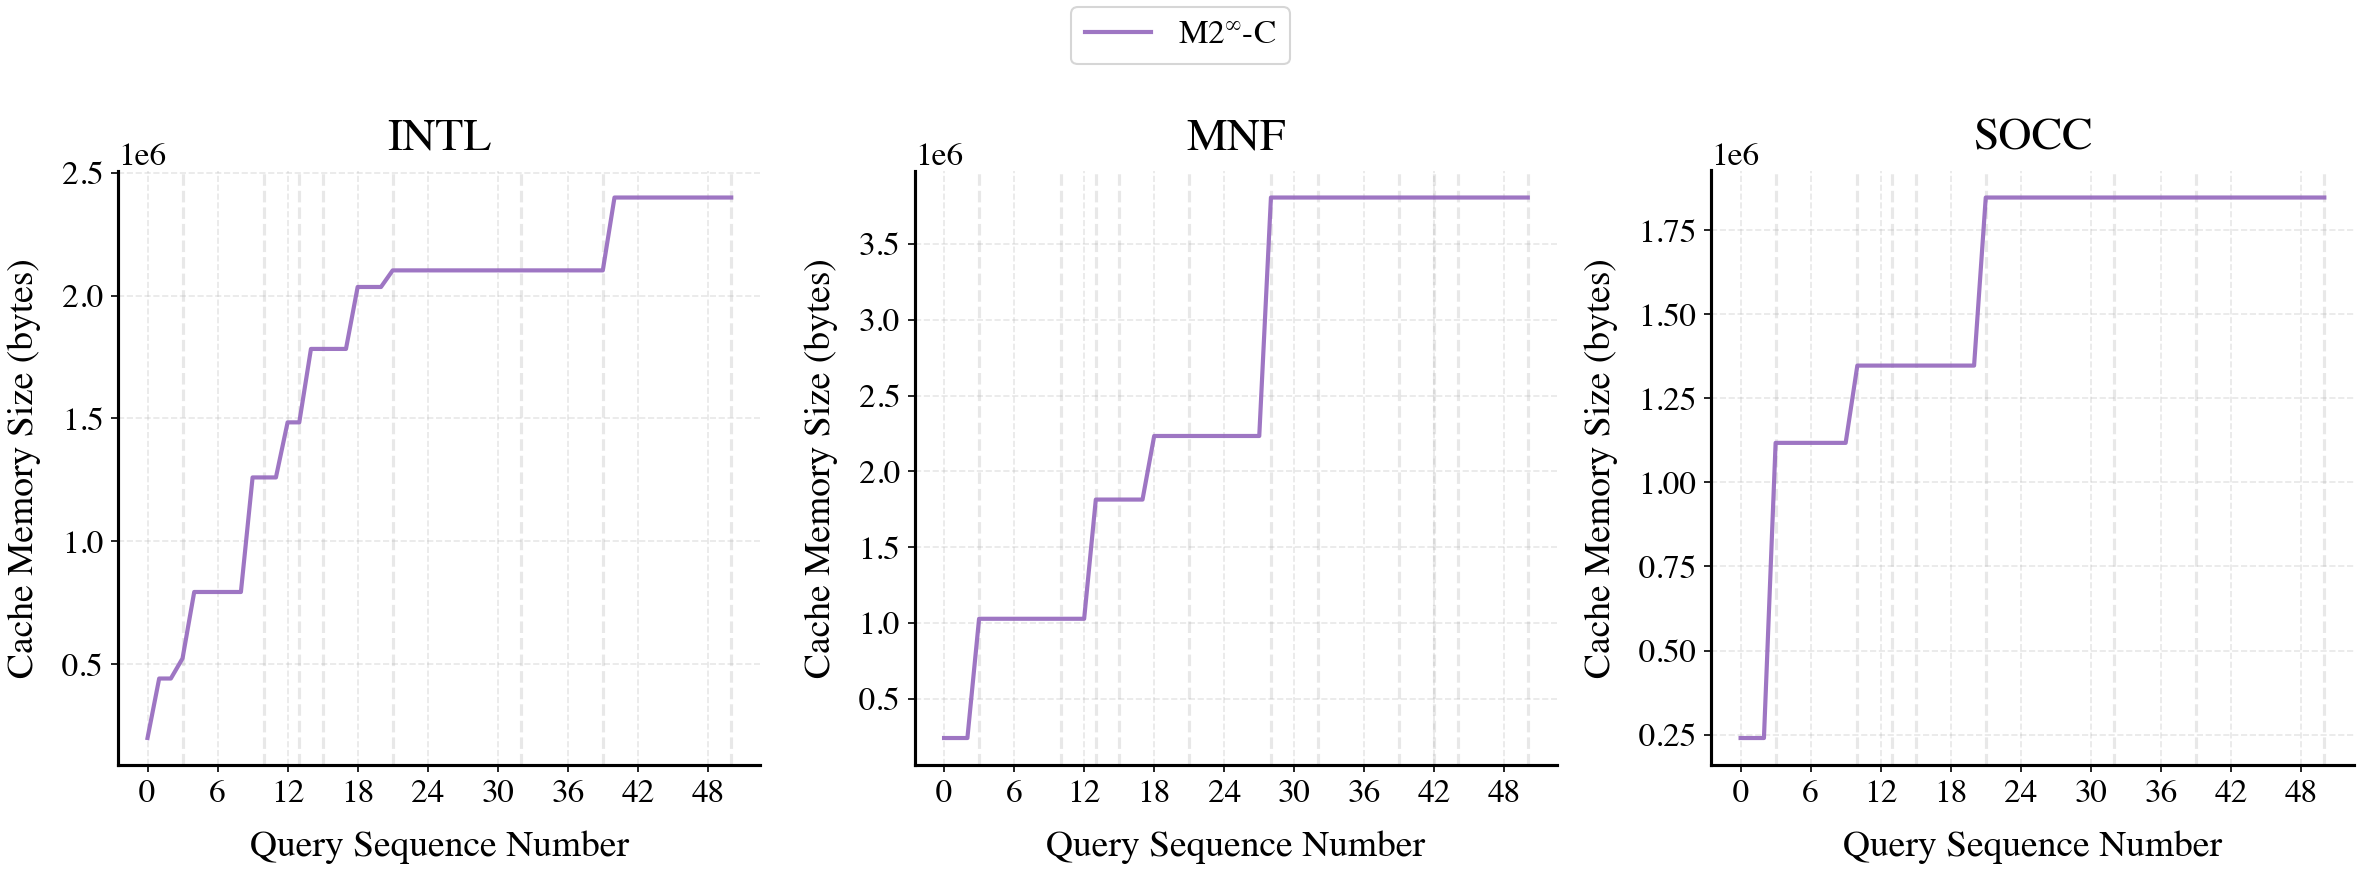

In [346]:
if all_combined is not None:
    # Query Execution Time Evolution - COMBINED PLOTTING CELL
    # This cell creates a single figure with subplots for all datasets
        # Create combined figure with subplots for all datasets
    n_datasets = len(all_datasets_mapped)
    cols = min(3, n_datasets)
    rows = (n_datasets + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(FONT_SIZE["figsize"][0], (FONT_SIZE["figsize"][1] - 1)*rows))
    if n_datasets == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    # Hide extra subplots if any
    for i in range(n_datasets, len(axes)):
        axes[i].set_visible(False)
    
    for i, dataset in enumerate(all_datasets_mapped):
        ax = axes[i]
        
        if dataset in results_by_dataset:
            dataset_df = results_by_dataset[dataset]
            run_count = dataset_df['run_count'].iloc[0]
            methods = dataset_df['method'].unique()
            
            # Add highlighting for pattern detection queries
            pattern_queries = dataset_df[dataset_df['operation'] == 'Pattern Detection']['query #'].unique()
            for query_num in pattern_queries:
                ax.axvline(x=query_num, color='lightgray', linestyle='--', alpha=0.5, zorder=0)

            # Define markers and plot each method
            markers = {'Pattern Detection': '*', 'Other': 'o'}
            method_handles = []
            
            for j, method in enumerate(methods):
                method_data = dataset_df[dataset_df['method'] == method].sort_values('query #')
                if(method_data['Cache Size (bytes)_mean'].isna().all()):
                    continue
                
                color = GLOBAL_METHOD_COLORS[method]
                
                line = ax.plot(
                    method_data['query #'], 
                    method_data['Cache Size (bytes)_mean'],
                    label=method,
                    alpha=0.9,
                    color=color, 
                    linestyle='-', 
                    linewidth=2,
                )
                method_handles.append(line[0])
            
            # Set labels and formatting
            ax.set_title(f'{dataset}', fontweight='bold', pad=10)
            ax.set_xlabel('Query Sequence Number')
            ax.set_ylabel('Cache Memory Size (bytes)')
            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
            # Collect legend handles from the first dataset only
            if i == 0:
                legend_handles = method_handles
                            
            # Apply styling
            set_publication_style(ax)
        else:
            ax.text(0.5, 0.5, f'No data\nfor {dataset}', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{dataset}', fontweight='bold', pad=10)
    
    if 'legend_handles' in locals():
            fig.legend(handles=legend_handles,
                      loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(method_names),
                      frameon=True)
    # Set overall title
    if SHOW_TITLES:
        fig.suptitle('Query Execution Time Evolution - All Datasets', fontsize=FONT_SIZE['title'], y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93 if SHOW_TITLES else 0.96)
    
    # Save combined figure
    plt.savefig(os.path.join(FIGURES_DIR, "memory_evolution_combined.pdf"))
    plt.savefig(os.path.join(FIGURES_DIR, "memory_evolution_combined.png"))
    plt.show()
else:
    print("No data available for plotting time evolution.")

# Performance Distribution Analysis 
Show mean run times using box plots

In [347]:
COMBINED = True

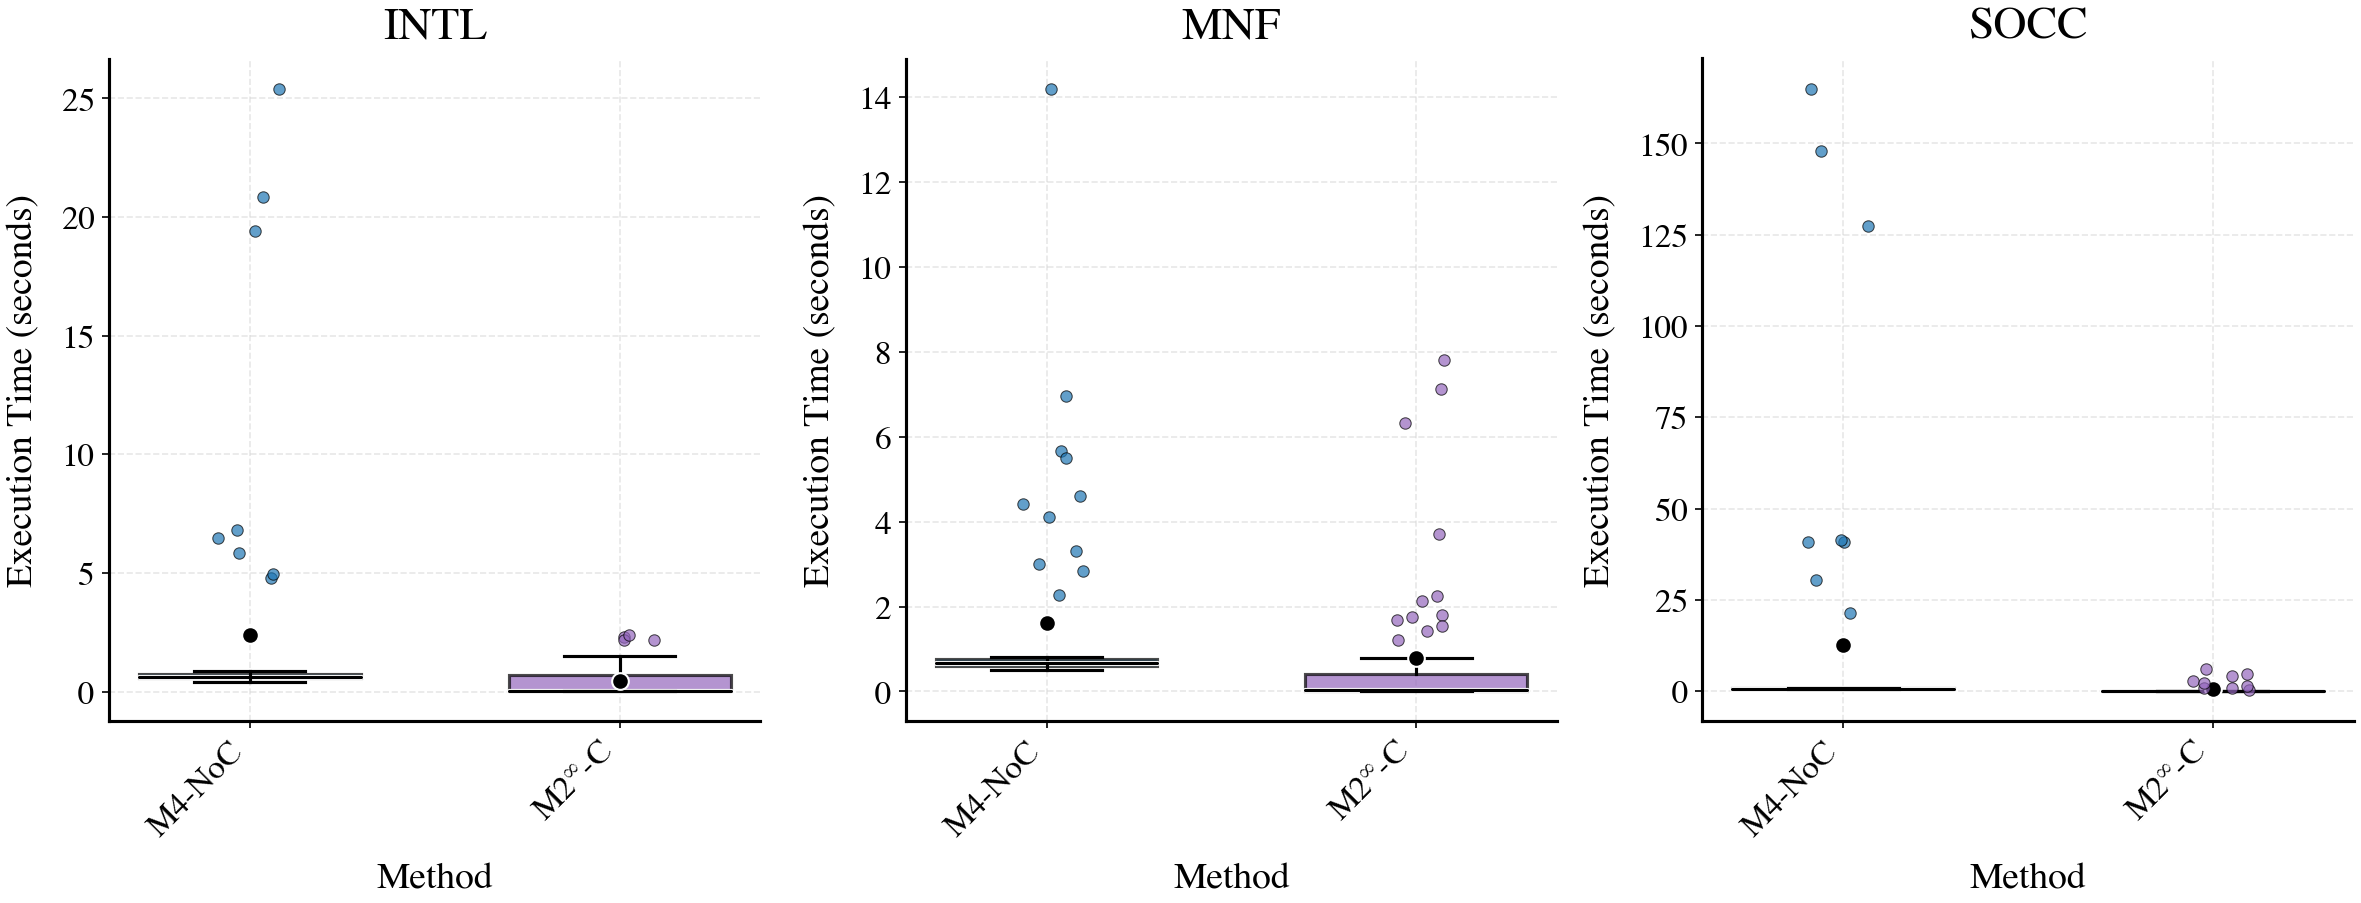

In [348]:
# Performance Distribution Analysis - COMBINED PLOTTING CELL
# This cell creates a single figure with subplots for all datasets

if all_combined is not None:
    if(COMBINED):
        # Create combined figure with subplots for all datasets
        n_datasets = len(all_datasets_mapped)
        cols = min(3, n_datasets)
        rows = (n_datasets + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(FONT_SIZE["figsize"][0], FONT_SIZE["figsize"][1]*rows))
        if n_datasets == 1:
            axes = [axes]
        elif rows == 1:
            axes = [axes] if cols == 1 else axes
        else:
            axes = axes.flatten()
        
        # Hide extra subplots if any
        for i in range(n_datasets, len(axes)):
            axes[i].set_visible(False)
        
        for i, dataset in enumerate(all_datasets_mapped):
            ax = axes[i]
            
            if dataset in raw_results_by_dataset:
                dataset_df = raw_results_by_dataset[dataset]
                run_count = len(dataset_df['run'].unique())
                methods = dataset_df['method'].unique()
                positions = np.arange(len(methods))
                width = 0.6
                
                # Create boxplot-like visualization using proper quartile statistics
                for j, method in enumerate(methods):
                    method_data = dataset_df[dataset_df['method'] == method]
                    mean_times_by_query = method_data.groupby(['query #'])['Time (sec)'].mean().reset_index()
                    
                    # Calculate proper boxplot statistics
                    data_values = mean_times_by_query['Time (sec)']
                    Q1 = data_values.quantile(0.25)
                    median_val = data_values.median()
                    Q3 = data_values.quantile(0.75)
                    mean_val = data_values.mean()
                    IQR = Q3 - Q1
                    
                    # Calculate whiskers using IQR method (1.5 * IQR)
                    whisker_low = Q1 - 1.5 * IQR
                    whisker_high = Q3 + 1.5 * IQR
                    
                    # Find actual whisker values (within data range)
                    min_val = data_values[data_values >= whisker_low].min()
                    max_val = data_values[data_values <= whisker_high].max()
                    
                    # Identify outliers
                    outliers = data_values[(data_values < whisker_low) | (data_values > whisker_high)]
                    
                    # Position for this box
                    x_pos = j
                    
                    # Draw box (from Q1 to Q3)
                    box_height = Q3 - Q1
                    box = plt.Rectangle(
                        (x_pos - width/2, Q1),
                        width, box_height,
                        alpha=0.7,
                        facecolor=GLOBAL_METHOD_COLORS[method],
                        edgecolor='black',
                        linewidth=1.5
                    )
                    ax.add_patch(box)
                    
                    # Draw median line
                    ax.plot([x_pos - width/2, x_pos + width/2], [median_val, median_val], 
                            color='white', linewidth=2.5, solid_capstyle='round')
                    ax.plot([x_pos - width/2, x_pos + width/2], [median_val, median_val], 
                            color='black', linewidth=1.5, solid_capstyle='round')
                    
                    # Draw whiskers
                    ax.plot([x_pos, x_pos], [min_val, Q1], 
                            color='black', linewidth=1.5, linestyle='-')
                    ax.plot([x_pos, x_pos], [Q3, max_val], 
                            color='black', linewidth=1.5, linestyle='-')
                    
                    # Draw caps on whiskers
                    whisker_width = width / 4
                    ax.plot([x_pos - whisker_width, x_pos + whisker_width], [min_val, min_val], 
                            color='black', linewidth=1.5)
                    ax.plot([x_pos - whisker_width, x_pos + whisker_width], [max_val, max_val], 
                            color='black', linewidth=1.5)
                    
                    # Draw mean point
                    ax.plot(x_pos, mean_val, 'o', color='white', markersize=8)
                    ax.plot(x_pos, mean_val, 'o', color='black', markersize=6)
                    
                    # Plot outliers as individual points
                    if len(outliers) > 0:
                        jitter = np.random.uniform(-width/6, width/6, size=len(outliers))
                        ax.scatter(
                            [x_pos + j for j in jitter], 
                            outliers.values,
                            s=30,
                            alpha=0.7,
                            color=GLOBAL_METHOD_COLORS[method],
                            edgecolor='black',
                            linewidth=0.5,
                            marker='o',
                            zorder=3
                        )
                    
                    # Plot non-outlier points with jitter (optional - can be removed for cleaner look)
                    # non_outliers = data_values[(data_values >= whisker_low) & (data_values <= whisker_high)]
                    # if len(non_outliers) > 0:
                    #     jitter = np.random.uniform(-width/8, width/8, size=len(non_outliers))
                    #     ax.scatter(
                    #         [x_pos + j for j in jitter], 
                    #         non_outliers.values,
                    #         s=15,
                    #         alpha=0.3,
                    #         color=GLOBAL_METHOD_COLORS[method],
                    #         edgecolor='none',
                    #         zorder=2
                    #     )
                
                # Set axis properties
                ax.set_xticks(positions)
                ax.set_xticklabels(methods, rotation=45, ha='right')
                ax.set_title(f'{dataset}', fontweight='bold', pad=10)
                ax.set_xlabel('Method')
                ax.set_ylabel('Execution Time (seconds)')
                
                # Apply styling
                set_publication_style(ax)
            else:
                ax.text(0.5, 0.5, f'No data\nfor {dataset}', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{dataset}', fontweight='bold', pad=10)
        
        # Set overall title
        if SHOW_TITLES:
            fig.suptitle('Query Time Distribution - All Datasets', fontsize=FONT_SIZE['title'], y=0.98)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.93 if SHOW_TITLES else 0.96)
        
        # Save combined figure
        plt.savefig(os.path.join(FIGURES_DIR, "mean_time_distribution_combined.pdf"))
        plt.savefig(os.path.join(FIGURES_DIR, "mean_time_distribution_combined.png"))
        plt.show()
    else:
        # We'll use raw_results_by_dataset to get the 
        for dataset in all_datasets:
            if dataset in raw_results_by_dataset:
                dataset_df = raw_results_by_dataset[dataset]
                run_count = len(dataset_df['run'].unique())
                
                # Create publication-ready chart for performance distribution
                fig, ax = plt.subplots(figsize=(FONT_SIZE["figsize"][0], FONT_SIZE["figsize"][1]))
                
                methods = dataset_df['method'].unique()
                positions = np.arange(len(methods))
                width = 0.6
                
                # Create a more sophisticated boxplot-like visualization using minimum times
                for i, method in enumerate(methods):
                    # Get data for this method
                    method_data = dataset_df[dataset_df['method'] == method]
                    
                    # Calculate the minimum time for each unique query across all runs
                    min_times_by_query = method_data.groupby(['query #'])['Time (sec)'].min().reset_index()
                    
                    # Calculate statistics on these minimum times
                    mean_val = min_times_by_query['Time (sec)'].mean()
                    median_val = min_times_by_query['Time (sec)'].median()
                    min_val = min_times_by_query['Time (sec)'].min()
                    max_val = min_times_by_query['Time (sec)'].max()
                    std_val = min_times_by_query['Time (sec)'].std()
                    
                    # Draw box - Ensure box doesn't go below zero
                    box_bottom = max(0, median_val - std_val/2)  # Use max() to prevent negative values
                    box_height = std_val
                    box = plt.Rectangle(
                        (i-width/2, box_bottom),
                        width, box_height,
                        alpha=0.7,
                        facecolor=GLOBAL_METHOD_COLORS[method],
                        edgecolor='black',
                        linewidth=1.5
                    )
                    ax.add_patch(box)
                    
                    # Draw median line
                    ax.plot([i-width/2, i+width/2], [median_val, median_val], 
                            color='white', linewidth=2.5, solid_capstyle='round')
                    ax.plot([i-width/2, i+width/2], [median_val, median_val], 
                            color='black', linewidth=1.5, solid_capstyle='round')
                    
                    # Draw whiskers (min-max) - Ensure whiskers don't go below zero
                    ax.plot([i, i], [max(0, min_val), box_bottom], 
                            color='black', linewidth=1.5, linestyle='-')
                    ax.plot([i, i], [box_bottom + box_height, max_val], 
                            color='black', linewidth=1.5, linestyle='-')
                    
                    # Draw caps on whiskers
                    whisker_width = width / 4
                    ax.plot([i-whisker_width, i+whisker_width], [max(0, min_val), max(0, min_val)], 
                            color='black', linewidth=1.5)
                    ax.plot([i-whisker_width, i+whisker_width], [max_val, max_val], 
                            color='black', linewidth=1.5)
                    
                    # Draw mean point
                    ax.plot(i, mean_val, 'o', color='white', markersize=8)
                    ax.plot(i, mean_val, 'o', color='black', markersize=6)
                    
                    # Add annotation with statistics
                    stats_text = (
                        f"n={len(min_times_by_query)}\n"
                        f"mean={mean_val:.2f}s\n"
                        f"median={median_val:.2f}s\n"
                        f"std={std_val:.2f}\n"
                        f"min={min_val:.2f}s\n"
                        f"max={max_val:.2f}s"
                    )
                    
                    # Improved stats text positioning strategy
                    text_x = i + width * 0.7  # Position to the right side of the box
                    text_y = (box_bottom + box_height + max_val) / 2  # Middle between box top and max whisker
                    
                    # Alternative positioning based on dataset characteristics
                    if max_val > mean_val * 3:  # If we have extreme outliers
                        text_y = median_val + std_val  # Place near the upper part of the box
                    
                    # Ensure text is always inside the plot area
                    y_min, y_max = ax.get_ylim()
                    text_y = min(max(text_y, y_min + (y_max - y_min) * 0.15), y_max * 0.85)
                    
                    # Add connecting line from box to annotation
                    # ax.annotate(
                    #     stats_text,
                    #     xy=(i, median_val),  # Start from the median line
                    #     xytext=(text_x, text_y),  # End at the text position
                    #     textcoords="data",
                    #     ha='left',
                    #     va='center',
                    #     bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.9),
                    #     arrowprops=dict(arrowstyle="-", color="gray", connectionstyle="arc3,rad=0.3")
                    # )
                
                # Set axis properties
                ax.set_xticks(positions)
                ax.set_xticklabels(methods)
                
                # Set titles and labels
                title = f'Query Time Distribution - {dataset}'
                subtitle = f'Using minimum query times across {run_count} runs'
                if(SHOW_TITLES):
                    ax.set_title(f'{title}\n{subtitle}', pad=20)
                ax.set_xlabel('Method')
                ax.set_ylabel('Execution Time (seconds)')
                
                # Plot actual data points with jitter for better visibility
                for i, method in enumerate(methods):
                    # Get data for this method
                    method_data = dataset_df[dataset_df['method'] == method]
                    
                    # Get minimum times for each query across runs
                    mean_times_by_query = method_data.groupby(['query #'])['Time (sec)'].mean().values
                    
                    # Create jitter for better point separation
                    jitter = np.random.uniform(-width/3, width/3, size=len(mean_times_by_query))
                    
                    # Plot individual points with semi-transparency
                    ax.scatter(
                        [i + j for j in jitter], 
                        mean_times_by_query,
                        s=30,
                        alpha=0.5,
                        color=GLOBAL_METHOD_COLORS[method],
                        edgecolor='black',
                        linewidth=0.5,
                        zorder=3
                    )
                
                # Apply publication styling but without legend
                set_publication_style(ax)
                
                # Adjust y-axis range
                y_min, y_max = ax.get_ylim()
                margin = (y_max - y_min) * 0.05
                ax.set_ylim(y_min - margin, y_max + margin)
                
                plt.tight_layout()
                
                # Save figure
                filename_safe = dataset.replace(' ', '_').lower()
                plt.savefig(os.path.join(FIGURES_DIR, f"min_time_distribution_{filename_safe}.pdf"))
                plt.savefig(os.path.join(FIGURES_DIR, f"min_time_distribution_{filename_safe}.png"))
                plt.show()

In [349]:
import re
from sklearn.metrics import f1_score, precision_score, recall_score

# Function to find ground truth pattern match files
def find_ground_truth_files(db, dataset):
    """
    Find all ground truth pattern match log files
    
    Parameters:
    -----------
    base_dir : str
        Base directory to search for ground truth files
        
    Returns:
    --------
    list: List of ground truth file information
    """ 
    # Get the absolute path to the pattern_matches directory
    pattern_dir = os.path.join("..", f"{outFolder}/pattern_matches/ground_truth/{db}/{dataset}")
    
    # Check if directory exists
    if not os.path.exists(pattern_dir):
        print(f"Directory '{pattern_dir}' does not exist.")
        return []
    
    # Find all ground truth log files
    gt_pattern = os.path.join(pattern_dir, "*.log")
    gt_files = glob.glob(gt_pattern)
    
    if not gt_files:
        print(f"No ground truth files found in '{pattern_dir}'.")
        return []
    
    # Parse ground truth files information
    gt_info = []
    method_pattern = re.compile(r"(.+?)_(\d+)_(\d+)_(.+?)\.log$")
    
    for file_path in gt_files:
        filename = os.path.basename(file_path)
        match = method_pattern.match(filename)
        
        if match:
            start_ts = match.group(1)
            end_ts = match.group(2)
            measure = match.group(3)
            time_unit = match.group(4)

            gt_info.append({
                'path': file_path,
                'database': db,
                'dataset': dataset,
                'start_ts': start_ts,
                'end_ts': end_ts,
                'measure': measure,
                'time_unit': time_unit,
                'filename': filename
            })
    
    print(f"Found {len(gt_info)} ground truth files.")
    return gt_info

# Function to find corresponding method files for a ground truth file
def find_method_file(gt_info, method, base_dir="pattern_matches"):
    """
    Find method files that correspond to a ground truth file
    
    Parameters:
    -----------
    gt_info : dict
        Ground truth file information
    method : string
        List of method information dictionaries
    base_dir : str
        Base directory to search for method files
        
    Returns:
    --------
    dict: Dictionary of method files
    """
    method_files = {}
    
    method_name = method["method"]
    # Construct a pattern to    
    # match files for this method and dataset
    method_pattern = f"{method_name}/{gt_info['database']}/{gt_info['dataset']}/{gt_info['start_ts']}_{gt_info['end_ts']}_{gt_info['measure']}_{gt_info['time_unit']}.log"
    method_path = os.path.join("..", f"{outFolder}/{base_dir}", method_pattern)

    if os.path.exists(method_path):
        return {
            'path': method_path,
            'method_name': method_name,
            'display_name': method["name"]
        }
    return None;


def extract_patterns(filepath):
    # Extract main [start to end] intervals per pattern
    with open(filepath, "r") as f:
        content = f.read()
    pattern = re.compile(r"Match #\d+: \[(\d+) to (\d+)\]")
    return set((int(m.group(1)), int(m.group(2))) for m in pattern.finditer(content))

def parse_aggregate_interval(time_unit_str):
    """
    Parse aggregate interval from time unit string.
    
    Parameters:
    -----------
    time_unit_str : str
        Time unit string like "AggregateInterval{500 Millis}" or "hour"
        
    Returns:
    --------
    int: Interval value in appropriate units, or None if not parseable
    """
    if not time_unit_str:
        return None, None
    
    # Pattern to match "AggregateInterval{number unit}"
    pattern = re.compile(r"AggregateInterval\{(\d+)\s+(\w+)\}", re.IGNORECASE)
    match = pattern.search(time_unit_str)
    
    if match:
        interval_value = int(match.group(1))
        interval_unit = match.group(2).lower()
        
        print(f"Parsed aggregate interval: {interval_value} {interval_unit}")
        return interval_value, interval_unit
    
    # If no aggregate interval pattern found, try to extract just numbers
    number_pattern = re.compile(r"(\d+)")
    number_match = number_pattern.search(time_unit_str)
    if number_match:
        return int(number_match.group(1)), None
    
    return None, None


def find_best_matching_patterns(gt_patterns, pred_patterns, tolerance):
    """
    Find best matching patterns using a more sophisticated algorithm.
    This version handles overlapping matches better and provides detailed analysis.
    
    Parameters:
    -----------
    gt_patterns : set
        Set of ground truth patterns
    pred_patterns : set
        Set of predicted patterns
    tolerance : int
        Maximum allowed difference in time units
        
    Returns:
    --------
    tuple: (matched_pairs, unmatched_gt, unmatched_pred, match_details)
    """
    gt_list = list(gt_patterns)
    pred_list = list(pred_patterns)
    
    # Calculate similarity matrix
    similarity_matrix = []
    match_details = []
    
    for i, gt_pattern in enumerate(gt_list):
        row = []
        for j, pred_pattern in enumerate(pred_list):
            start_diff = abs(gt_pattern[0] - pred_pattern[0])
            end_diff = abs(gt_pattern[1] - pred_pattern[1])
            
            # Calculate similarity score (lower is better)
            if start_diff <= tolerance and end_diff <= tolerance:
                score = start_diff + end_diff  # Total difference
                row.append(score)
                match_details.append({
                    'gt_idx': i,
                    'pred_idx': j,
                    'gt_pattern': gt_pattern,
                    'pred_pattern': pred_pattern,
                    'start_diff': start_diff,
                    'end_diff': end_diff,
                    'total_diff': score
                })
            else:
                row.append(float('inf'))  # No match
        similarity_matrix.append(row)
    
    # Find best matches using greedy approach
    matched_pairs = []
    used_gt = set()
    used_pred = set()
    
    # Sort potential matches by similarity score
    valid_matches = [m for m in match_details if m['total_diff'] < float('inf')]
    valid_matches.sort(key=lambda x: x['total_diff'])
    
    for match in valid_matches:
        gt_idx = match['gt_idx']
        pred_idx = match['pred_idx']
        
        if gt_idx not in used_gt and pred_idx not in used_pred:
            matched_pairs.append(match)
            used_gt.add(gt_idx)
            used_pred.add(pred_idx)
    
    # Find unmatched patterns
    unmatched_gt = [gt_list[i] for i in range(len(gt_list)) if i not in used_gt]
    unmatched_pred = [pred_list[i] for i in range(len(pred_list)) if i not in used_pred]
    
    return matched_pairs, unmatched_gt, unmatched_pred, match_details

def compute_f1_with_tolerance(gt_file, pred_file, tolerance=2):
    """
    Compute F1 score with tolerance for pattern matching.
    
    Parameters:
    -----------
    gt_file : str
        Path to ground truth file
    pred_file : str
        Path to prediction file
    tolerance : int
        Maximum allowed difference in time units
        
    Returns:
    --------
    tuple: (precision, recall, f1, true_positives, false_positives, false_negatives, match_analysis)
    """
    gt_patterns = extract_patterns(gt_file)
    pred_patterns = extract_patterns(pred_file)
    
    print(f"Ground truth patterns: {len(gt_patterns)}")
    print(f"Predicted patterns: {len(pred_patterns)}")
    
    # Find matching patterns with improved algorithm
    matched_pairs, unmatched_gt, unmatched_pred, match_details = find_best_matching_patterns(
        gt_patterns, pred_patterns, tolerance
    )
    
    # Calculate metrics
    true_positives = len(matched_pairs)
    false_positives = len(unmatched_pred)
    false_negatives = len(unmatched_gt)
    
    # Calculate precision, recall, and F1
    if true_positives + false_positives == 0:
        precision = 1.0 if true_positives + false_negatives == 0 else 0.0
    else:
        precision = true_positives / (true_positives + false_positives)
    
    if true_positives + false_negatives == 0:
        recall = 1.0 if true_positives + false_positives == 0 else 0.0
    else:
        recall = true_positives / (true_positives + false_negatives)
    
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"Tolerance: {tolerance} time units")
    print(f"True Positives (matched): {true_positives}")
    print(f"False Positives (unmatched predictions): {false_positives}")
    print(f"False Negatives (unmatched ground truth): {false_negatives}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    # Detailed analysis of matches
    match_analysis = {
        'matched_pairs': matched_pairs,
        'unmatched_gt': unmatched_gt,
        'unmatched_pred': unmatched_pred,
        'all_match_details': match_details
    }
    
    if matched_pairs:
        print(f"\nMatched patterns (showing time differences):")
        for i, match in enumerate(matched_pairs[:5]):  # Show first 5 matches
            gt_p = match['gt_pattern']
            pred_p = match['pred_pattern']
            print(f"  Match {i+1}: GT{gt_p} ↔ Pred{pred_p} (Δstart={match['start_diff']}, Δend={match['end_diff']})")
        if len(matched_pairs) > 5:
            print(f"  ... and {len(matched_pairs) - 5} more matches")
    
    if unmatched_gt:
        print(f"\nUnmatched ground truth patterns:")
        for i, gt_p in enumerate(unmatched_gt[:3]):  # Show first 3
            print(f"  GT{gt_p}")
        if len(unmatched_gt) > 3:
            print(f"  ... and {len(unmatched_gt) - 3} more")
    
    if unmatched_pred:
        print(f"\nUnmatched predicted patterns:")
        for i, pred_p in enumerate(unmatched_pred[:3]):  # Show first 3
            print(f"  Pred{pred_p}")
        if len(unmatched_pred) > 3:
            print(f"  ... and {len(unmatched_pred) - 3} more")
    
    return precision, recall, f1, true_positives, false_positives, false_negatives, match_analysis

def compute_f1(gt_file, pred_file):
    """Legacy function for backward compatibility - uses tolerance=2"""
    precision, recall, f1, _, _, _, _ = compute_f1_with_tolerance(gt_file, pred_file, tolerance=2)
    return f1

Starting pattern detection accuracy comparison with improved tolerance calculation...
Found 8 ground truth files.
Parsing time unit: AggregateInterval{5 Minutes}
Parsed aggregate interval: 5 minutes
Using tolerance based on aggregate interval: 1500000ms (2 × 5 minutes)
Ground truth: 2557893091919_2558926987855_2_AggregateInterval{5 Minutes}.log
Found 22 ground truth patterns

Comparing M2$^\infty$-C vs ground truth:
Method file: 2557893091919_2558926987855_2_AggregateInterval{5 Minutes}.log
Time unit: AggregateInterval{5 Minutes}, Using tolerance: 1500000ms
Found 23 predicted patterns
Ground truth patterns: 22
Predicted patterns: 23
Tolerance: 1500000 time units
True Positives (matched): 21
False Positives (unmatched predictions): 2
False Negatives (unmatched ground truth): 1
Precision: 0.9130
Recall:    0.9545
F1 Score:  0.9333

Matched patterns (showing time differences):
  Match 1: GT(2557927500000, 2557946400000) ↔ Pred(2557927500000, 2557946400000) (Δstart=0, Δend=0)
  Match 2: GT

,dataset,method,method_id,measure,time_unit,tolerance_used,precision,recall,f1,gt_patterns,pred_patterns,correct_patterns,true_positives,false_positives,false_negatives
0,INTL,M2$^\infty$-C,approxOls,2,AggregateInterval{5 Minutes},1500000,0.913043,0.954545,0.933333,22,23,21,21,2,1
1,INTL,M2$^\infty$-C,approxOls,2,AggregateInterval{30 Minutes},9000000,0.500000,1.000000,0.666667,1,2,1,1,1,0
2,INTL,M2$^\infty$-C,approxOls,2,AggregateInterval{30 Minutes},9000000,1.000000,1.000000,1.000000,0,0,0,0,0,0
3,INTL,M2$^\infty$-C,approxOls,2,AggregateInterval{15 Minutes},4500000,0.750000,0.900000,0.818182,10,12,9,9,3,1
4,INTL,M2$^\infty$-C,approxOls,2,AggregateInterval{30 Minutes},9000000,1.000000,0.714286,0.833333,7,5,5,5,0,2
5,INTL,M2$^\infty$-C,approxOls,2,AggregateInterval{2 Hours},36000000,1.000000,1.000000,1.000000,0,0,0,0,0,0
6,INTL,M2$^\infty$-C,approxOls,2,AggregateInterval{10 Minutes},3000000,1.000000,0.916667,0.956522,12,11,11,11,0,1
7,INTL,M2$^\infty$-C,approxOls,2,AggregateInterval{6 Hours},108000000,1.000000,1.000000,1.000000,0,0,0,0,0,0
8,MNF,M2$^\infty$-C,approxOls,1,AggregateInterval{100 Millis},500,1.000000,1.000000,1.000000,4,4,4,4,0,0
9,MNF,M2$^\infty$-C,approxOls,1,AggregateInterval{200 Millis},1000,1.000000,1.000000,1.000000,5,5,5,5,0,0



Tolerance used by time unit:


,time_unit,tolerance_used,count
0,AggregateInterval{1 Minutes},300000,1
1,AggregateInterval{10 Minutes},3000000,1
2,AggregateInterval{100 Millis},500,3
3,AggregateInterval{15 Minutes},4500000,2
4,AggregateInterval{2 Hours},36000000,1
5,AggregateInterval{2 Minutes},600000,1
6,AggregateInterval{2 Seconds},10000,1
7,AggregateInterval{200 Millis},1000,3
8,AggregateInterval{250 Millis},1250,1
9,AggregateInterval{30 Minutes},9000000,4



Detailed Analysis Examples:

intel_lab_exp_M2$^\infty$-C_2:
  Matched pairs: 0
  Unmatched GT: 0
  Unmatched Pred: 0

manufacturing_exp_M2$^\infty$-C_1:
  Matched pairs: 1
  Unmatched GT: 0
  Unmatched Pred: 0
  Average time shift - Start: 0ms, End: 50ms

Pattern detection metrics saved to: ../figures/pattern_detection_metrics.csv


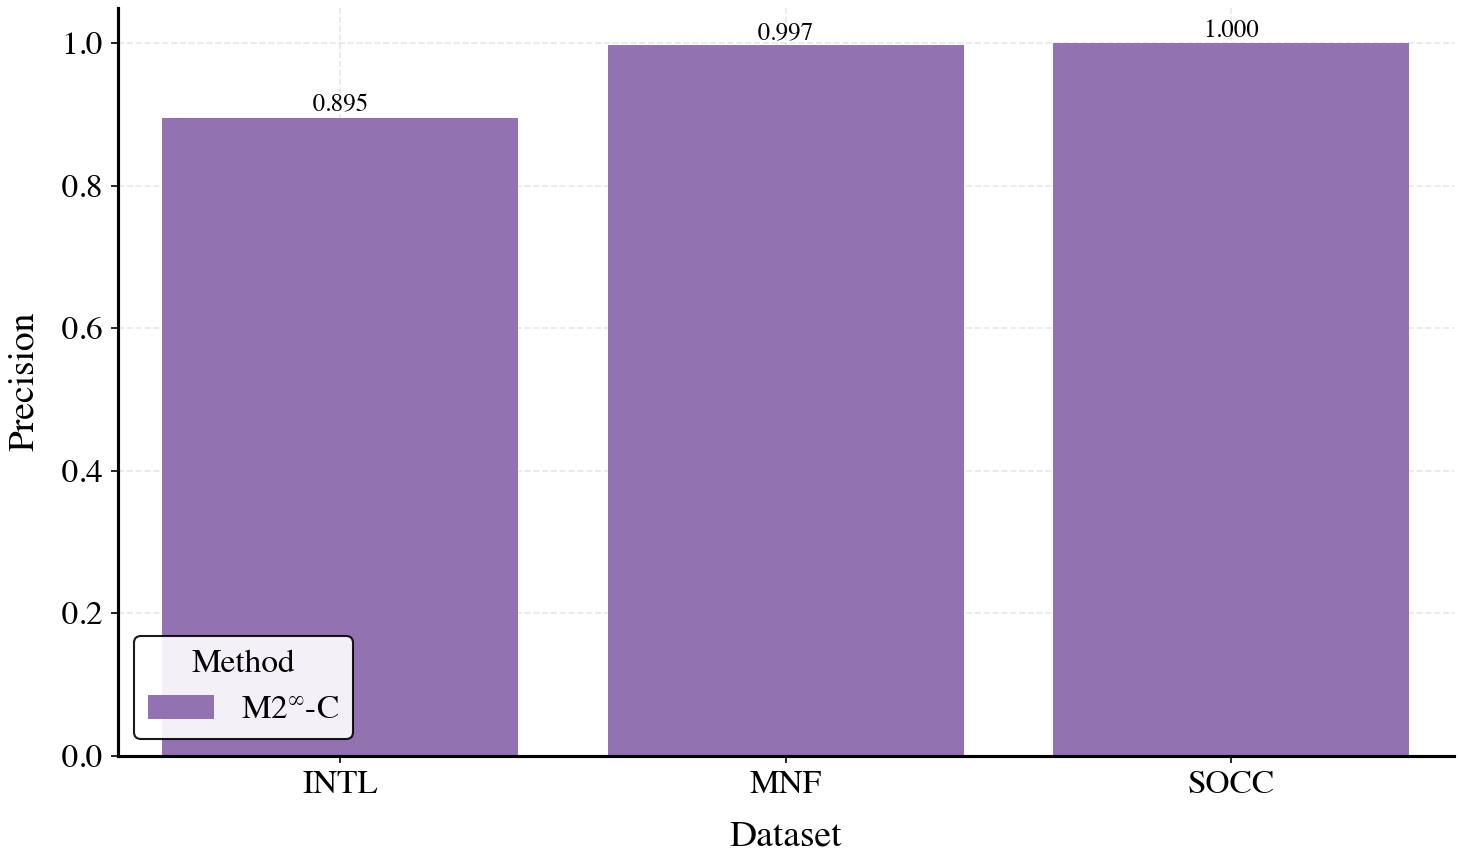

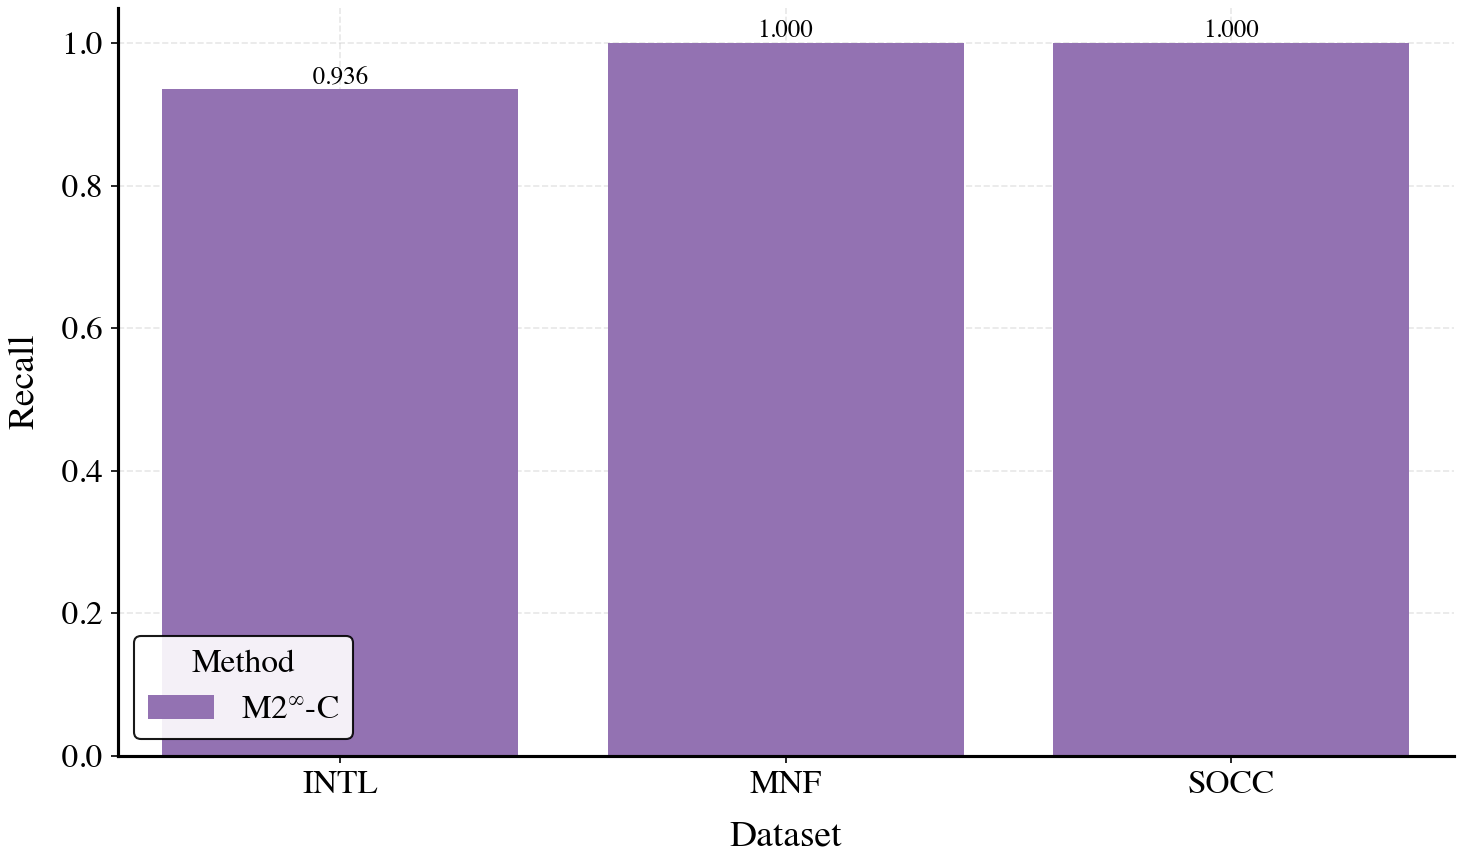

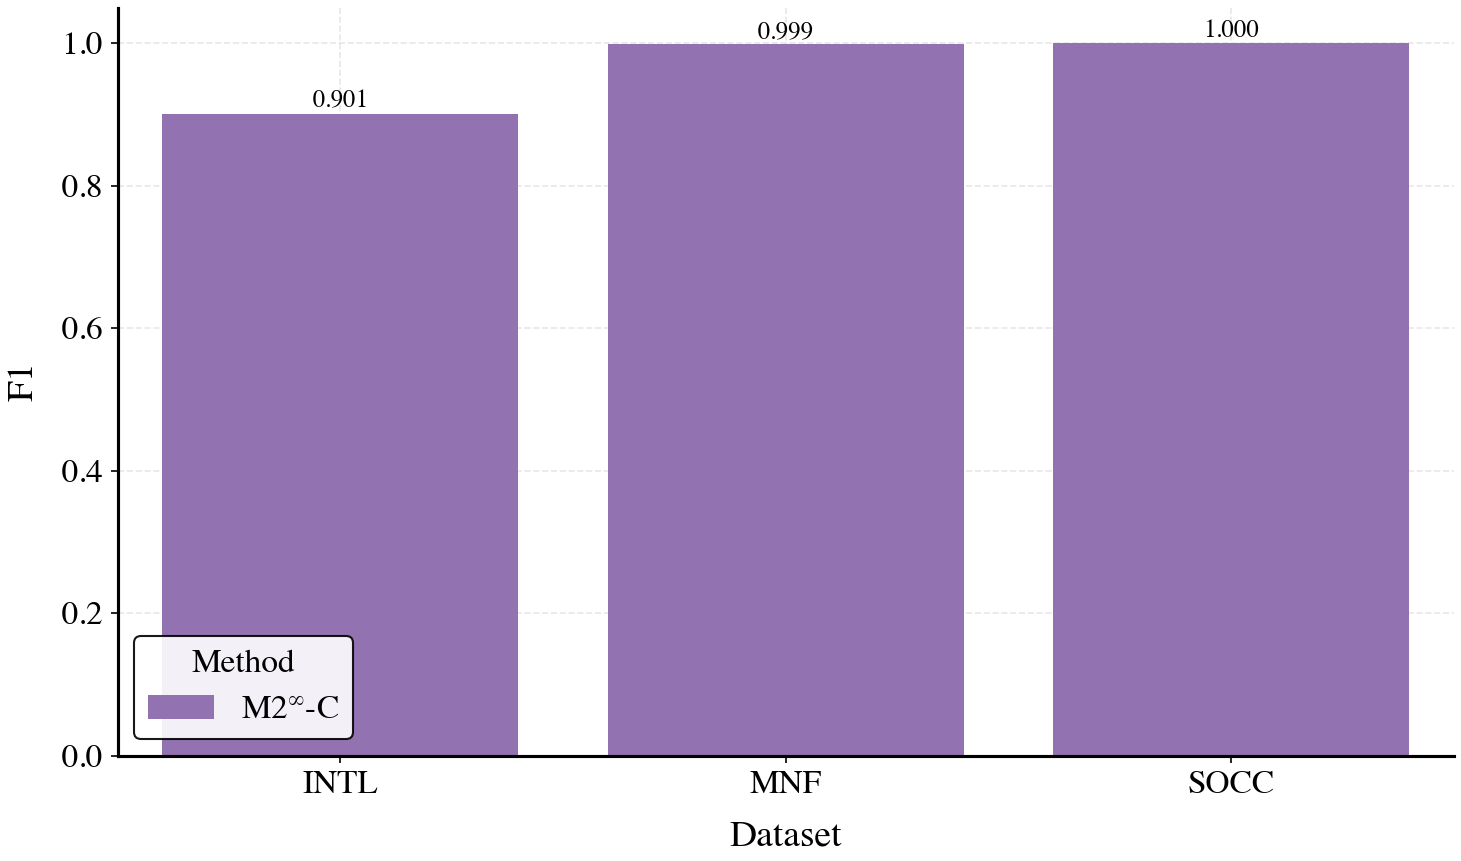


Overall method performance summary:


,method,avg_precision,std_precision,avg_recall,std_recall,avg_f1,std_f1,num_datasets
0,M2$^\infty$-C,0.967943,0.106181,0.980944,0.059108,0.970131,0.077062,3


In [350]:
# Function to determine tolerance based on time unit
def get_tolerance_for_time_unit(time_unit):
    """
    Determine appropriate tolerance based on time unit.
    Fixed to properly handle aggregate intervals.
    
    Parameters:
    -----------
    time_unit : str
        Time unit from the filename (e.g., 'AggregateInterval{30 Minutes}', 'hour', 'day')
        
    Returns:
    --------
    int: Tolerance value in milliseconds
    """
    print(f"Parsing time unit: {time_unit}")
    
    # First try to parse aggregate interval
    interval_value, interval_unit = parse_aggregate_interval(time_unit)
    
    multiplier = 5

    if interval_value is not None and interval_unit is not None:
        # Convert to milliseconds based on unit
        unit_to_ms = {
            'millis': 1,
            'milliseconds': 1,
            'seconds': 1000,
            'minutes': 60 * 1000,
            'hours': 60 * 60 * 1000,
            'days': 24 * 60 * 60 * 1000
        }
        
        # Find matching unit (case insensitive)
        times = None
        for unit, ms in unit_to_ms.items():
            if unit.lower() in interval_unit.lower():
                times = ms
                break
        
        if times is not None:
            # For aggregate intervals, use 2-3 intervals as tolerance
            # This accounts for slight misalignments in pattern boundaries
            tolerance = interval_value * times * multiplier
            print(f"Using tolerance based on aggregate interval: {tolerance}ms (2 × {interval_value} {interval_unit})")
            return tolerance
    
    # Fallback tolerance mapping for traditional time units
    tolerance_map = {
        'minutes': multiplier * 60 * 1000,      # 2 minutes
        'hours': multiplier * 60 * 60 * 1000,  # 2 hours  
        'days': multiplier * 24 * 60 * 60 * 1000,  # 2 days
        'seconds': multiplier * 1000,           # 2 seconds
        'millis': multiplier,                   # 2 milliseconds
    }
    
    # Try to find matching key (case insensitive)
    for unit, tolerance in tolerance_map.items():
        if unit.lower() in time_unit.lower():
            print(f"Using tolerance based on time unit '{unit}': {tolerance}ms")
            return tolerance
    
    # Default tolerance if time unit not recognized
    default_tolerance = multiplier * 1000  
    print(f"Could not parse time unit '{time_unit}', using default tolerance: {default_tolerance}ms")
    return default_tolerance

# Compare pattern detection accuracy for all methods against ground truth
def compare_pattern_detection(methods, base_dir="pattern_matches"):
    """
    Compare pattern detection accuracy for all methods against ground truth
    
    Parameters:
    -----------
    methods : list
        List of method information dictionaries
    base_dir : str
        Base directory containing pattern match files
    
    Returns:
    --------
    pd.DataFrame: DataFrame containing accuracy metrics
    """
    results = []
    detailed_analysis = {}  # Store detailed match analysis
    
    # For each ground truth file, find corresponding method files and compare
    for i, method in enumerate(METHODS):
        if(i == 0): continue  # Skip the first method (baseline)
        for dataset in all_datasets:
            gt_files = find_ground_truth_files(method['database'], dataset)

            for gt_file in gt_files:
                # Find method files for this ground truth
                method_file = find_method_file(gt_file, method, base_dir)
                if not method_file:
                    print(f"No method file found for method {method['name']} and dataset {dataset}")
                    continue
                
                # Determine tolerance based on time unit
                tolerance = get_tolerance_for_time_unit(gt_file['time_unit'])
                
                # Load ground truth patterns
                gt_path = gt_file['path']
                try:
                    gt_patterns = extract_patterns(gt_path)
                    print(f"Ground truth: {os.path.basename(gt_path)}")
                    print(f"Found {len(gt_patterns)} ground truth patterns")
                except Exception as e:
                    print(f"Error loading ground truth file: {str(e)}")
                    continue
                
                # Compare each method against ground truth
                pred_path = method_file['path']
                display_name = method_file['display_name']
                
                print(f"\nComparing {display_name} vs ground truth:")
                print(f"Method file: {os.path.basename(pred_path)}")
                print(f"Time unit: {gt_file['time_unit']}, Using tolerance: {tolerance}ms")
                
                try:
                    # Load predicted patterns
                    pred_patterns = extract_patterns(pred_path)
                    print(f"Found {len(pred_patterns)} predicted patterns")
                    
                    # Calculate metrics with tolerance
                    precision, recall, f1, true_positives, false_positives, false_negatives, match_analysis = compute_f1_with_tolerance(
                        gt_path, pred_path, tolerance
                    )
                    
                    # Store detailed analysis
                    analysis_key = f"{dataset}_{display_name}_{gt_file['measure']}"
                    detailed_analysis[analysis_key] = match_analysis
                    
                    # Count number of patterns
                    num_gt_patterns = len(gt_patterns)
                    num_pred_patterns = len(pred_patterns)
                    num_correct_patterns = true_positives
                    
                    results.append({
                        'dataset': DATASET_MAP[dataset],
                        'method': display_name,
                        'method_id': method_file['method_name'],
                        'measure': gt_file['measure'],
                        'time_unit': gt_file['time_unit'],
                        'tolerance_used': tolerance,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1,
                        'gt_patterns': num_gt_patterns,
                        'pred_patterns': num_pred_patterns,
                        'correct_patterns': num_correct_patterns,
                        'true_positives': true_positives,
                        'false_positives': false_positives,
                        'false_negatives': false_negatives
                    })
                    
                except Exception as e:
                    print(f"Error comparing {display_name} to ground truth: {str(e)}")
    
    # Convert results to DataFrame
    if results:
        results_df = pd.DataFrame(results)
        # Store detailed analysis for later inspection
        results_df._detailed_analysis = detailed_analysis
        return results_df
    else:
        print("No comparison results generated.")
        return None

# Run the pattern detection accuracy comparison
print("Starting pattern detection accuracy comparison with improved tolerance calculation...")
accuracy_results = compare_pattern_detection(METHODS, "pattern_matches")

if accuracy_results is not None:
    print("\nSummary of pattern detection accuracy:")
    display(accuracy_results)
    
    # Show tolerance information
    if 'tolerance_used' in accuracy_results.columns:
        tolerance_summary = accuracy_results.groupby(['time_unit', 'tolerance_used']).size().reset_index(name='count')
        print("\nTolerance used by time unit:")
        display(tolerance_summary)
    
    # Show some detailed analysis examples
    if hasattr(accuracy_results, '_detailed_analysis'):
        print("\nDetailed Analysis Examples:")
        for key, analysis in list(accuracy_results._detailed_analysis.items())[:2]:  # Show first 2
            print(f"\n{key}:")
            print(f"  Matched pairs: {len(analysis['matched_pairs'])}")
            print(f"  Unmatched GT: {len(analysis['unmatched_gt'])}")
            print(f"  Unmatched Pred: {len(analysis['unmatched_pred'])}")
            
            if analysis['matched_pairs']:
                avg_start_diff = np.mean([m['start_diff'] for m in analysis['matched_pairs']])
                avg_end_diff = np.mean([m['end_diff'] for m in analysis['matched_pairs']])
                print(f"  Average time shift - Start: {avg_start_diff:.0f}ms, End: {avg_end_diff:.0f}ms")
    
    # Create visualizations if we have results
    if not accuracy_results.empty:
        # Save the data to CSV format
        csv_data = accuracy_results.groupby(['dataset', 'method']).agg({
            'precision': 'mean',
            'recall': 'mean', 
            'f1': 'mean'
        }).reset_index()
        csv_data[['precision', 'recall', 'f1']] = csv_data[['precision', 'recall', 'f1']].round(3)

        csv_filename = os.path.join(FIGURES_DIR, "pattern_detection_metrics.csv")
        csv_data.to_csv(csv_filename, index=False)
        print(f"\nPattern detection metrics saved to: {csv_filename}")
        
        # Create 3 separate plots for individual metrics
        metrics = ['precision', 'recall', 'f1']
        
        for metric in metrics:
            # Group by dataset and method
            summary = accuracy_results.groupby(['dataset', 'method'])[metric].mean().reset_index()
            
            # Create individual figure for this metric
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Create the grouped bar chart with consistent colors
            method_names = summary['method'].unique()
            palette = [GLOBAL_METHOD_COLORS.get(method, '#1f77b4') for method in method_names]
            sns.barplot(data=summary, x='dataset', y=metric, hue='method', ax=ax, palette=palette)
            
            # Set titles and labels
            if SHOW_TITLES:
                ax.set_title(f"Pattern Detection {metric.capitalize()} by Dataset and Method", pad=15)
            ax.set_xlabel('Dataset')
            ax.set_ylabel(metric.capitalize())
            
            # Apply publication styling
            set_publication_style(ax, legend_title='Method')
            
            # Adjust y-axis limits
            ax.set_ylim(0, 1.05)
            
            # Add text labels above bars
            for p in ax.patches:
                if p.get_height() > 0:  # Only annotate non-zero bars
                    ax.annotate(f"{p.get_height():.3f}", 
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha = 'center', va = 'bottom')
            
            plt.tight_layout()
            
            # Save individual figure
            plt.savefig(os.path.join(FIGURES_DIR, f"pattern_detection_{metric}.pdf"))
            plt.savefig(os.path.join(FIGURES_DIR, f"pattern_detection_{metric}.png"))
            plt.show()
        
        # Create a summary table showing overall metrics by method
        method_summary = accuracy_results.groupby('method').agg({
            'precision': ['mean', 'std'],
            'recall': ['mean', 'std'],
            'f1': ['mean', 'std'],
            'dataset': 'nunique'
        }).reset_index()
        
        # Flatten the multi-level column names
        method_summary.columns = ['_'.join(col).strip('_') for col in method_summary.columns]
        
        # Rename columns for clarity
        method_summary = method_summary.rename(columns={
            'method_': 'method',
            'precision_mean': 'avg_precision',
            'precision_std': 'std_precision',
            'recall_mean': 'avg_recall',
            'recall_std': 'std_recall',
            'f1_mean': 'avg_f1',
            'f1_std': 'std_f1',
            'dataset_nunique': 'num_datasets'
        })
        
        print("\nOverall method performance summary:")
        display(method_summary)
else:
    print("No pattern match accuracy results available.")

## Visual Similarity Comparison between Query Results

Compare the visual similarity of query results between different methods and the ground truth (M4-NoC) using two complementary metrics:

1. **Structural Similarity Index Measure (SSIM)**: Measures perceptual similarity between images, considering luminance, contrast, and structure. Values range from 0 to 1, where 1 means identical images.

2. **Pixel Difference Percentage**: Measures the percentage of pixels that differ between two images. Values range from 0% to 100%, where 0% means identical images and 100% means completely different images.

**Note:** The analysis is separated into:
1. **Calculation Cell**: Computes both SSIM scores and pixel difference percentages, caching results to `./analysis_cache/similarity_data.pkl`
2. **Plotting Cell**: Generates visualizations using cached data for both metrics
3. **Cache Management Cell**: Utilities to clear cache and force recalculation

This separation allows you to:
- Run expensive calculations once and reuse results
- Quickly regenerate plots without recalculating similarity metrics
- Force recalculation when needed by setting `force_recalculate = True` or clearing cache

The two metrics provide complementary information:
- **SSIM** is better for understanding perceptual similarity and structural differences
- **Pixel Difference Percentage** provides a straightforward measure of how many pixels actually differ between images

In [351]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import tempfile
import shutil
from PIL import Images

# Import cairo_plot module for plotting time series
sys.path.append("..")
from cairo_plot import plot, compute_ssim, compute_pixel_difference_percentage

ImportError: cannot import name 'Images' from 'PIL' (/Users/vasilisstamatopoulos/Documents/Works/ATHENA/PhD/Code/pattern-cache/.conda/lib/python3.11/site-packages/PIL/__init__.py)

In [ ]:

# Function to convert timestamp to epoch milliseconds in UTC
def convert_to_epoch_millis_utc(timestamp_str):
    """
    Convert timestamp string to epoch milliseconds in UTC.
    
    Parameters:
    -----------
    timestamp_str : str or int or float
        Timestamp in various formats (ISO string, epoch seconds, epoch milliseconds)
        
    Returns:
    --------
    int: Epoch milliseconds in UTC
    """
    from datetime import datetime, timezone
    import dateutil.parser
    
    if pd.isna(timestamp_str) or timestamp_str is None:
        return None
    
    # If it's already a number, assume it's epoch time
    if isinstance(timestamp_str, (int, float)):
        # Check if it's in seconds (typical range) or milliseconds
        if timestamp_str < 1e12:  # Likely in seconds
            return int(timestamp_str * 1000)
        else:  # Likely already in milliseconds
            return int(timestamp_str)
    
    # Convert string to number if possible
    try:
        num_val = float(timestamp_str)
        if num_val < 1e12:  # Likely in seconds
            return int(num_val * 1000)
        else:  # Likely already in milliseconds
            return int(num_val)
    except (ValueError, TypeError):
        pass
    
    # Try to parse as ISO datetime string
    try:
        dt = dateutil.parser.parse(timestamp_str)
        # Convert to UTC if timezone aware, otherwise assume UTC
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
        else:
            dt = dt.astimezone(timezone.utc)
        return int(dt.timestamp() * 1000)
    except:
        print(f"Warning: Could not parse timestamp: {timestamp_str}")
        return None

# Function to find all query CSV files for a specific dataset and method
def find_query_csvs(base_dir, method, database, dataset):
    """
    Find all query result CSV files for a specific dataset and method.
    
    Parameters:
    -----------
    base_dir : str
        Base directory path
    method : str
        Method name (e.g., 'm4', 'm4Inf')
    database : str
        Database name (e.g., 'influx')
    dataset : str
        Dataset name
        
    Returns:
    --------
    list: List of dictionaries containing query information
    """
    query_dir = os.path.join(base_dir, method, database, dataset)
    query_files = []
    
    # Check if the directory exists
    if not os.path.exists(query_dir):
        print(f"Directory not found: {query_dir}")
        return query_files
    
    # Find all run directories
    run_dirs = glob.glob(os.path.join(query_dir, "run_*"))
    
    for run_dir in run_dirs:
        run_name = os.path.basename(run_dir)
        result_csv = os.path.join(run_dir, "results.csv")
        
        if not os.path.exists(result_csv):
            print(f"Results CSV not found: {result_csv}")
            continue
            
        df_result = pd.read_csv(result_csv)
        print(f"Loaded results CSV with {len(df_result)} rows")
        
        # Find all query directories within this run
        query_dirs = glob.glob(os.path.join(run_dir, "query_*"))
        
        for query_dir in query_dirs:
            query_name = os.path.basename(query_dir)
            query_id = int(query_name.split("_")[1])
            
            # Get query time range from results CSV
            query_row = df_result[df_result['query #'] == query_id]
            if query_row.empty:
                print(f"Query {query_id} not found in results CSV")
                continue
                
            query_start_raw = query_row['from'].values[0]
            query_end_raw = query_row['to'].values[0]
            
            # Convert to epoch milliseconds in UTC
            query_start_millis = convert_to_epoch_millis_utc(query_start_raw)
            query_end_millis = convert_to_epoch_millis_utc(query_end_raw)
            
            if query_start_millis is None or query_end_millis is None:
                print(f"Could not parse timestamps for query {query_id}: {query_start_raw} -> {query_end_raw}")
                continue
            
            print(f"Query {query_id}: {query_start_raw} -> {query_start_millis}, {query_end_raw} -> {query_end_millis}")
            
            # Find all CSV files in this query directory
            csv_files = glob.glob(os.path.join(query_dir, "*.csv"))
            
            for csv_file in csv_files:
                measure_id = os.path.basename(csv_file).split(".")[0]
                
                query_files.append({
                    'path': csv_file,
                    'run': run_name,
                    'query': query_name,
                    'query_id': query_id,
                    'measure': measure_id,
                    'dataset': dataset,
                    'method': method,
                    'start_time': query_start_millis,
                    'end_time': query_end_millis,
                    'duration': query_end_millis - query_start_millis,
                    'from_raw': query_start_raw,
                    'to_raw': query_end_raw
                })
    
    return query_files

# Function to generate plot images and compute similarity metrics
def compute_query_similarity_metrics(datasets, methods, temp_dir):
    """
    Generate plots and compute SSIM scores and pixel difference percentages between methods and ground truth.
    
    Parameters:
    -----------
    datasets : list
        List of dataset names
    methods : list
        List of method configurations
    temp_dir : str
        Temporary directory for storing images
        
    Returns:
    --------
    pd.DataFrame: DataFrame containing SSIM scores and pixel difference percentages
    """
    similarity_results = []
    
    # Get the first method as ground truth
    gt_method = methods[0]
    
    for dataset in datasets:
        print(f"Processing dataset: {dataset}")
        
        # Find all query CSVs for ground truth method
        gt_csvs = find_query_csvs(
            gt_method['path'], 
            gt_method['method'], 
            gt_method['database'], 
            dataset
        )

        if not gt_csvs:
            print(f"No ground truth CSVs found for dataset {dataset}")
            continue
        
        # Group ground truth files by query and measure
        gt_by_query = {}
        for gt_csv in gt_csvs:
            key = (gt_csv['query_id'], gt_csv['measure'])
            gt_by_query[key] = gt_csv
        
        # For each comparison method
        for method_idx, method in enumerate(methods[1:], 1):  # Skip the ground truth method
            method_name = method['name']
            print(f"  Comparing {method_name} with ground truth")
            
            # Find all query CSVs for this method
            method_csvs = find_query_csvs(
                method['path'], 
                method['method'], 
                method['database'], 
                dataset
            )
            
            if not method_csvs:
                print(f"  No CSVs found for method {method_name}")
                continue
            
            # Group method files by query and measure
            method_by_query = {}
            for method_csv in method_csvs:
                key = (method_csv['query_id'], method_csv['measure'])
                method_by_query[key] = method_csv
            
            # Find common queries between ground truth and method
            common_keys = set(gt_by_query.keys()) & set(method_by_query.keys())
            print(f"  Found {len(common_keys)} common queries to compare")
            
            # For each common query, generate plots and compute similarity metrics
            for query_key in common_keys:
                query_id, measure = query_key
                
                gt_csv = gt_by_query[query_key]
                method_csv = method_by_query[query_key]
                
                try:
                    # Load CSV data
                    gt_df = pd.read_csv(gt_csv['path'])
                    method_df = pd.read_csv(method_csv['path'])
                    
                    # Use the converted epoch milliseconds for plot range
                    query_start = gt_csv['start_time']
                    query_end = gt_csv['end_time']
                                        
                    # Create temporary image files
                    gt_img_path = os.path.join(temp_dir, f"{dataset}_{query_id}_{measure}_gt.png")
                    method_img_path = os.path.join(temp_dir, f"{dataset}_{query_id}_{measure}_method{method_idx}.png")
                
                    # Generate plots using cairo_plot with epoch milliseconds
                    plot(gt_df, measure, gt_img_path.replace('.png', ''), 1000, 600, query_start, query_end)
                    plot(method_df, measure, method_img_path.replace('.png', ''), 1000, 600, query_start, query_end)
                    
                    # Compute SSIM between the two images
                    ssim_score = compute_ssim(gt_img_path, method_img_path)
                    
                    # Compute pixel difference percentage between the two images
                    pixel_diff_percentage = compute_pixel_difference_percentage(gt_img_path, method_img_path)
                    
                    # Save results with time information
                    similarity_results.append({
                        'dataset': dataset,
                        'query_id': query_id,
                        'measure': measure,
                        'method': method_name,
                        'ssim': ssim_score,
                        'pixel_diff_percentage': pixel_diff_percentage,
                        'start_time': query_start,
                        'end_time': query_end,
                        'duration': gt_csv['duration'],
                        'from_raw': gt_csv['from_raw'],
                        'to_raw': gt_csv['to_raw']
                    })
                    
                except Exception as e:
                    print(f"  Error processing {dataset} query {query_id} measure {measure}: {str(e)}")
    
    # Convert results to DataFrame
    if similarity_results:
        similarity_df = pd.DataFrame(similarity_results)
        return similarity_df
    else:
        print("No similarity results generated.")
        return None

# Check if similarity data is already cached


print("Computing similarity metrics...")

# Create temporary directory for images
temp_dir = tempfile.mkdtemp()

try:
    print(f"Created temporary directory: {temp_dir}")
    
    # Compute similarity metrics
    print("Computing SSIM scores and pixel difference percentages between query results...")
    similarity_df = compute_query_similarity_metrics(all_datasets, METHODS, temp_dir)
    
    if similarity_df is not None and not similarity_df.empty:
        # Display summary of similarity metrics
        print("\nSummary of similarity metrics by dataset and method:")
        similarity_summary = similarity_df.groupby(['dataset', 'method'])[['ssim', 'pixel_diff_percentage']].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()
        display(similarity_summary)
        
        # Display time range information if available
        if 'start_time' in similarity_df.columns:
            print("\nQuery time range summary (epoch milliseconds UTC):")
            time_summary = similarity_df.groupby(['dataset', 'method']).agg({
                'start_time': ['min', 'max'],
                'end_time': ['min', 'max'],
                'duration': ['mean', 'median', 'std']
            }).reset_index()
            display(time_summary)
            
            # Also show some example raw timestamps for verification
            print("\nExample timestamp conversions:")
            sample_data = similarity_df[['dataset', 'method', 'query_id', 'from_raw', 'to_raw', 'start_time', 'end_time', 'duration']].head(3)
            display(sample_data)
    else:
        print("No similarity results available.")
        similarity_df = None
        similarity_summary = None
finally:
    # Clean up the temporary directory
    if 'temp_dir' in locals():
        # shutil.rmtree(temp_dir)
        print(f"Removed temporary directory: {temp_dir}")

# For backward compatibility, create ssim_df and ssim_summary variables
if 'similarity_df' in locals() and similarity_df is not None:
    ssim_df = similarity_df.copy()
    ssim_summary = similarity_df.groupby(['dataset', 'method'])['ssim'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()
else:
    ssim_df = None
    ssim_summary = None

In [ ]:
# Similarity Metrics Plotting - COMBINED PLOTTING CELL
# This cell creates combined figures with subplots for all datasets

if 'similarity_df' in globals() and similarity_df is not None and not similarity_df.empty:
    print("Generating combined similarity metrics visualizations...")
    
    # Get unique datasets and methods
    datasets = similarity_df['dataset'].unique()
    methods = similarity_df['method'].unique()
    
    # Create a mapping of methods to colors
    method_color_map = {}
    for method in methods:
        method_color_map[method] = GLOBAL_METHOD_COLORS.get(method, '#1f77b4')
    
    # Save similarity data to CSV format
    csv_data = similarity_df.groupby(['dataset', 'method']).agg({
        'ssim': 'mean',
        'pixel_diff_percentage': 'mean'
    }).reset_index()
    
    csv_filename = os.path.join(FIGURES_DIR, "similarity_metrics.csv")
    csv_data.to_csv(csv_filename, index=False)
    print(f"\nSimilarity metrics saved to: {csv_filename}")
    
    # Create combined box plots for each metric
    metrics_info = [
        {
            'metric': 'ssim',
            'title': 'SSIM Scores vs Ground Truth (M4-NoC) - All Datasets',
            'ylabel': 'SSIM Score',
            'filename': 'ssim_boxplots_combined',
            'y_limits': (max(0, similarity_df['ssim'].min() - 0.05), min(1.0, similarity_df['ssim'].max() + 0.05))
        },
        {
            'metric': 'pixel_diff_percentage',
            'title': 'Pixel Difference % vs Ground Truth (M4-NoC) - All Datasets',
            'ylabel': 'Pixel Difference (%)',
            'filename': 'pixel_diff_boxplots_combined',
            'y_limits': None
        }
    ]
    
    for metric_info in metrics_info:
        # Create combined figure with subplots
        n_datasets = len(datasets)
        cols = min(3, n_datasets)
        rows = (n_datasets + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(FONT_SIZE["figsize"][0], FONT_SIZE["figsize"][1] *rows))
        if n_datasets == 1:
            axes = [axes]
        elif rows == 1:
            axes = [axes] if cols == 1 else axes
        else:
            axes = axes.flatten()
        
        # Hide extra subplots if any
        for i in range(n_datasets, len(axes)):
            axes[i].set_visible(False)
        
        for ds_idx, dataset in enumerate(datasets):
            ax = axes[ds_idx]
            
            # Filter data for this dataset
            dataset_data = similarity_df[similarity_df['dataset'] == dataset]
            
            if not dataset_data.empty:
                dataset_methods = dataset_data['method'].unique()
                positions = np.arange(len(dataset_methods))
                width = 0.6
                
                for method_idx, method in enumerate(dataset_methods):
                    # Get data for this method
                    data_values = dataset_data[dataset_data['method'] == method][metric_info['metric']]
                    
                    if len(data_values) == 0:
                        continue
                    
                    # Calculate proper boxplot statistics
                    Q1 = data_values.quantile(0.25)
                    median_val = data_values.median()
                    Q3 = data_values.quantile(0.75)
                    mean_val = data_values.mean()
                    IQR = Q3 - Q1
                    
                    # Calculate whiskers using IQR method (1.5 * IQR)
                    whisker_low = Q1 - 1.5 * IQR
                    whisker_high = Q3 + 1.5 * IQR
                    
                    # Find actual whisker values (within data range)
                    min_val = data_values[data_values >= whisker_low].min()
                    max_val = data_values[data_values <= whisker_high].max()
                    
                    # Identify outliers
                    outliers = data_values[(data_values < whisker_low) | (data_values > whisker_high)]
                    
                    # Position for this box
                    x_pos = method_idx
                    
                    # Draw box (from Q1 to Q3)
                    box_height = Q3 - Q1
                    box = plt.Rectangle(
                        (x_pos - width/2, Q1),
                        width, box_height,
                        alpha=0.7,
                        facecolor=GLOBAL_METHOD_COLORS[method],
                        edgecolor='black',
                        linewidth=1.5
                    )
                    ax.add_patch(box)
                    
                    # Draw median line
                    ax.plot([x_pos - width/2, x_pos + width/2], [median_val, median_val], 
                            color='white', linewidth=2.5, solid_capstyle='round')
                    ax.plot([x_pos - width/2, x_pos + width/2], [median_val, median_val], 
                            color='black', linewidth=1.5, solid_capstyle='round')
                    
                    # Draw whiskers
                    ax.plot([x_pos, x_pos], [min_val, Q1], 
                            color='black', linewidth=1.5, linestyle='-')
                    ax.plot([x_pos, x_pos], [Q3, max_val], 
                            color='black', linewidth=1.5, linestyle='-')
                    
                    # Draw caps on whiskers
                    whisker_width = width / 4
                    ax.plot([x_pos - whisker_width, x_pos + whisker_width], [min_val, min_val], 
                            color='black', linewidth=1.5)
                    ax.plot([x_pos - whisker_width, x_pos + whisker_width], [max_val, max_val], 
                            color='black', linewidth=1.5)
                    
                    # Draw mean point
                    ax.plot(x_pos, mean_val, 'o', color='white', markersize=8)
                    ax.plot(x_pos, mean_val, 'o', color='black', markersize=6)
                    
                    # Plot outliers as individual points
                    if len(outliers) > 0:
                        jitter = np.random.uniform(-width/6, width/6, size=len(outliers))
                        ax.scatter(
                            [x_pos + j for j in jitter], 
                            outliers.values,
                            s=30,
                            alpha=0.7,
                            color=GLOBAL_METHOD_COLORS[method],
                            edgecolor='black',
                            linewidth=0.5,
                            marker='o',
                            zorder=3
                        )
                
                # Set axis properties
                ax.set_xticks(positions)
                ax.set_xticklabels(methods, rotation=45, ha='right')
                ax.set_title(f'{dataset}', fontweight='bold', pad=10)
                ax.set_xlabel('Method')
                ax.set_ylabel(metric_info['ylabel'])
                
                if metric_info['y_limits']:
                    ax.set_ylim(metric_info['y_limits'])
                
                # Add legend only to the first subplot
                if ds_idx == 0:
                    legend_handles = [plt.Rectangle((0,0),1,1, facecolor=method_color_map[method], 
                                                   edgecolor='black', alpha=0.7, label=method) 
                                      for method in dataset_methods if method in method_color_map]
                    # ax.legend(handles=legend_elements, title="Method", loc='upper right')
                
                # Apply styling
                set_publication_style(ax)
            else:
                ax.text(0.5, 0.5, f'No data\nfor {dataset}', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{dataset}', fontweight='bold', pad=10)
        
        # Set overall title
        if SHOW_TITLES:
            fig.suptitle(metric_info['title'], fontsize=FONT_SIZE['title'], y=0.92)
            
        # if 'legend_handles' in locals():
        #     fig.legend(handles=legend_handles,
        #               loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(method_names),
        #               frameon=True)
        plt.tight_layout()
        plt.subplots_adjust(top=0.87 if SHOW_TITLES else 0.90)
        
        # Save combined figure
        plt.savefig(os.path.join(FIGURES_DIR, f"{metric_info['filename']}.pdf"))
        plt.savefig(os.path.join(FIGURES_DIR, f"{metric_info['filename']}.png"))
        plt.show()
    
    # Display summary statistics
    print("\n=== SIMILARITY METRICS SUMMARY ===")
    print("\nSSIM Scores Summary:")
    print(similarity_df.groupby(['dataset', 'method'])['ssim'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(4))
    
    print("\nPixel Difference Percentage Summary:")
    print(similarity_df.groupby(['dataset', 'method'])['pixel_diff_percentage'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2))
    
    print("\nCombined similarity metrics visualizations completed!")
else:
    print("No similarity data available for plotting.")